Equation: y = -0.21644920910362087*x+543.6525659182455
Equation: y = 0.6837209224950543*x+342.966656409166

Stopped at iteration number 2
Equation: y = -0.291294995183214*x+292.78305456038845
Equation: y = -0.6456123060869177*x+374.26093421894075

Stopped at iteration number 2
Equation: y = 0.42069840095663524*x+93.72272607787178
Equation: y = 0.3602638673798067*x+112.49609717151523
Equation: y = 0.5098536790588502*x+53.13135757105914

Stopped at iteration number 3
Equation: y = 0.9442212860359978*x+134.6311398221322
Equation: y = -1.4257113906925385*x+823.0533232262092

Stopped at iteration number 2
Equation: y = 0.9907143966402685*x+-66.9245164137302
Equation: y = -135.18416671069212*x+42030.14098538967

Stopped at iteration number 2
Equation: y = -1.6830152898223245*x+752.4884981601062

Stopped at iteration number 1
Equation: y = 74.5082663532211*x+-15331.848044970235
Equation: y = 2.0699972232044233*x+-109.999239069753
Equation: y = 6.085071123625779*x+-1168.1915298742276
Equation:

/tmp/ipykernel_6004/3983056821.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 6))


Equation: y = -0.5386747337429724*x+305.91889185664513
Equation: y = 0.5800877063229193*x+41.32141698212709

Stopped at iteration number 2
Equation: y = -1.4470542656164929*x+392.0902911255496
Equation: y = -0.2521505785532473*x+148.07320181972426

Stopped at iteration number 2
Equation: y = -0.4857991369076713*x+355.2723900902763

Stopped at iteration number 1
Equation: y = 1.25841970933036*x+210.95871116676034
Equation: y = 0.4993355151416143*x+356.25318247798634

Stopped at iteration number 2
Equation: y = -3.5682912514433354*x+910.2839687128719

Stopped at iteration number 1
Equation: y = 11.110527463044525*x+-1728.7769196359532

Stopped at iteration number 1
Equation: y = -6.944232092031729*x+1581.0758703626161

Stopped at iteration number 1
Equation: y = -0.31403246366901405*x+501.4953177410162
Equation: y = -0.15020632324789981*x+476.0497954054396
Equation: y = -0.08367668653188122*x+444.88288106233273

Stopped at iteration number 3
Equation: y = 0.6299283857218314*x+-72.0949102

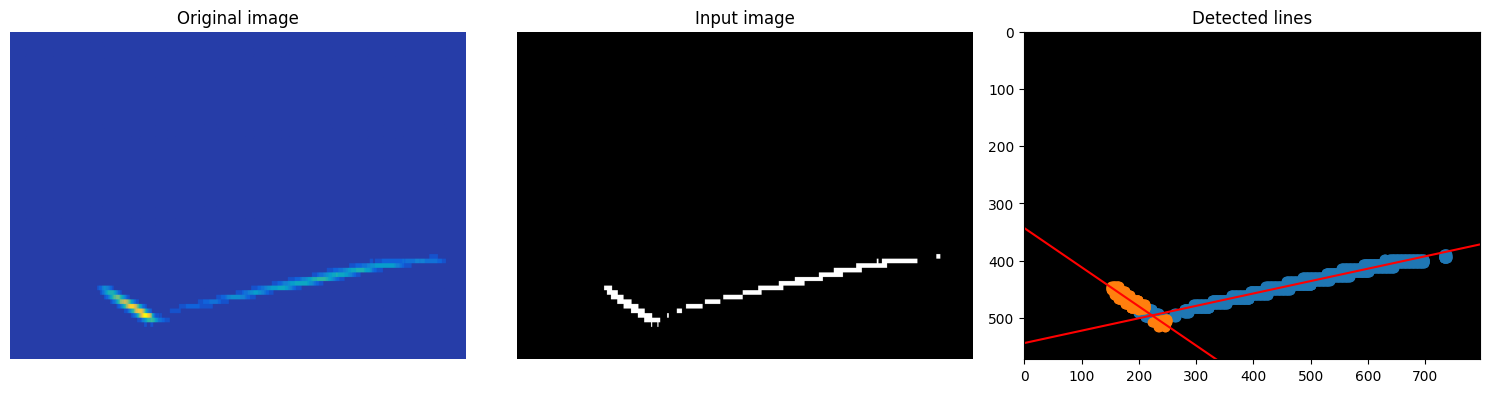

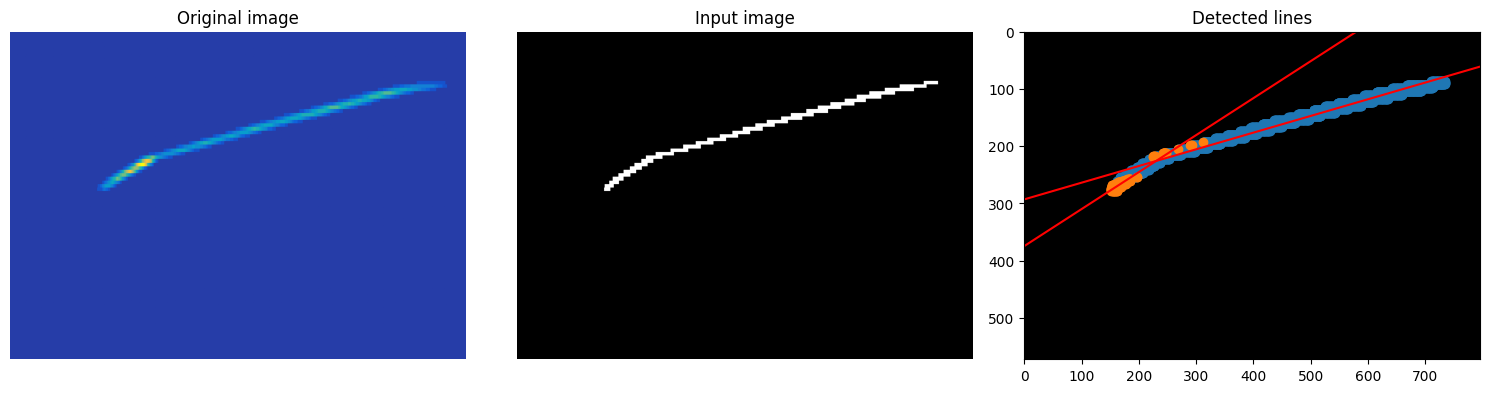

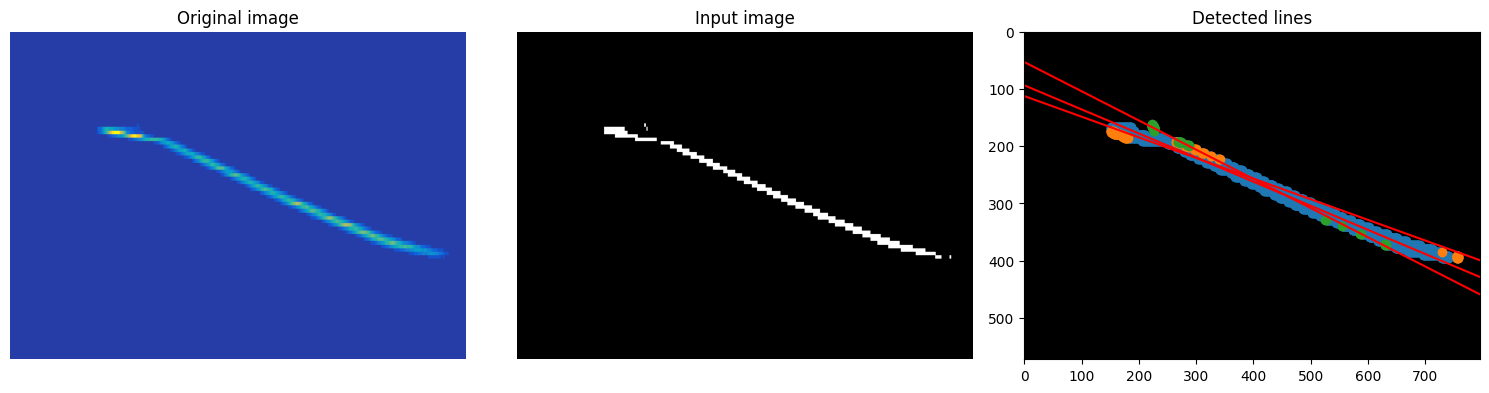

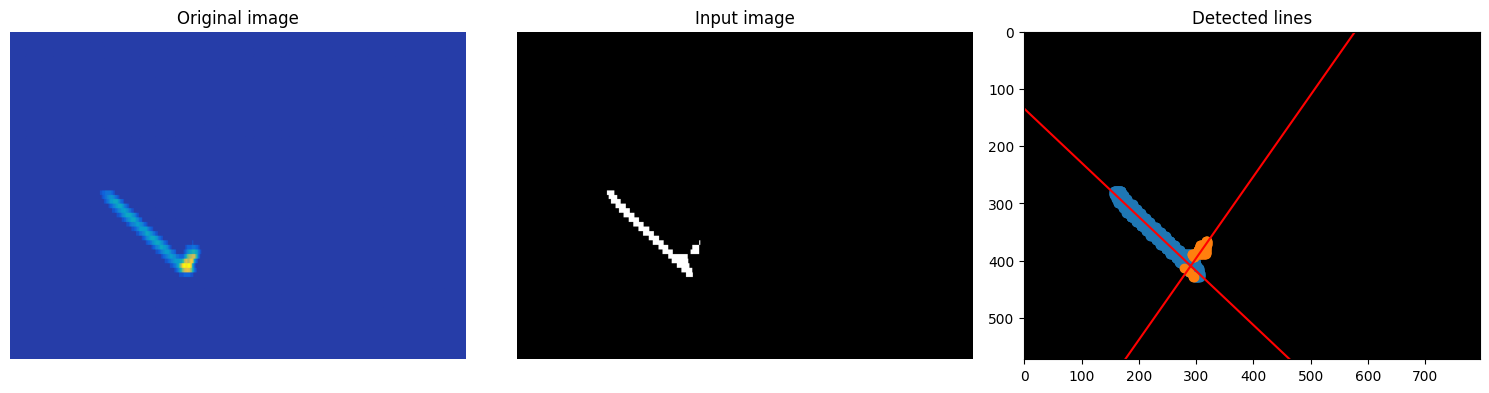

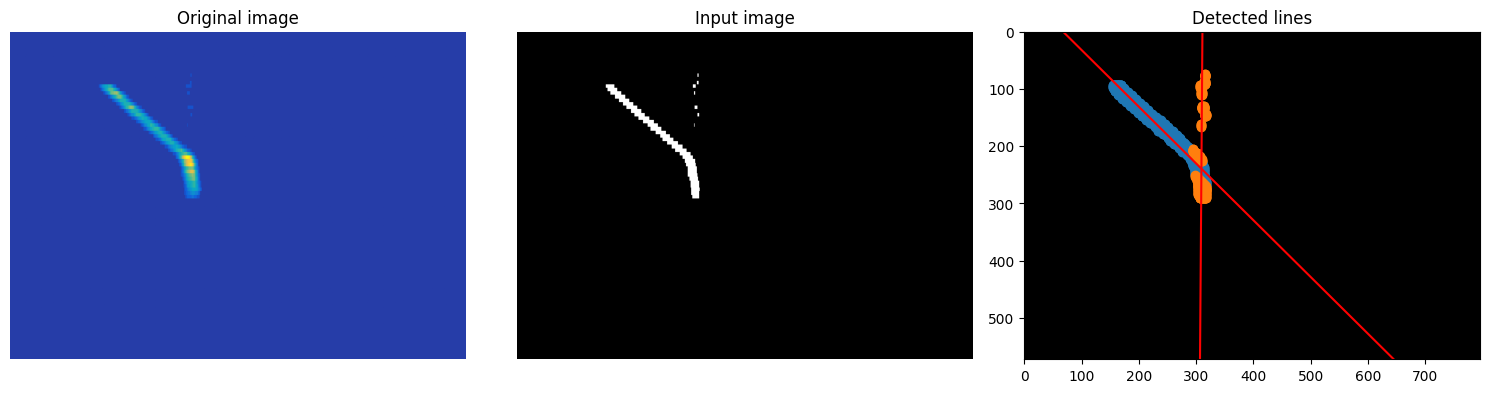

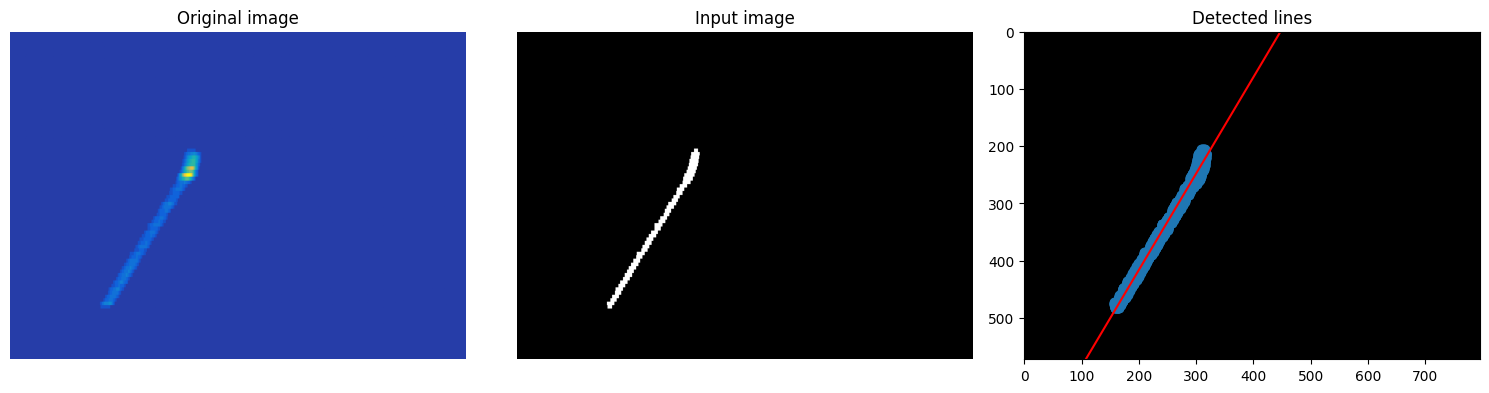

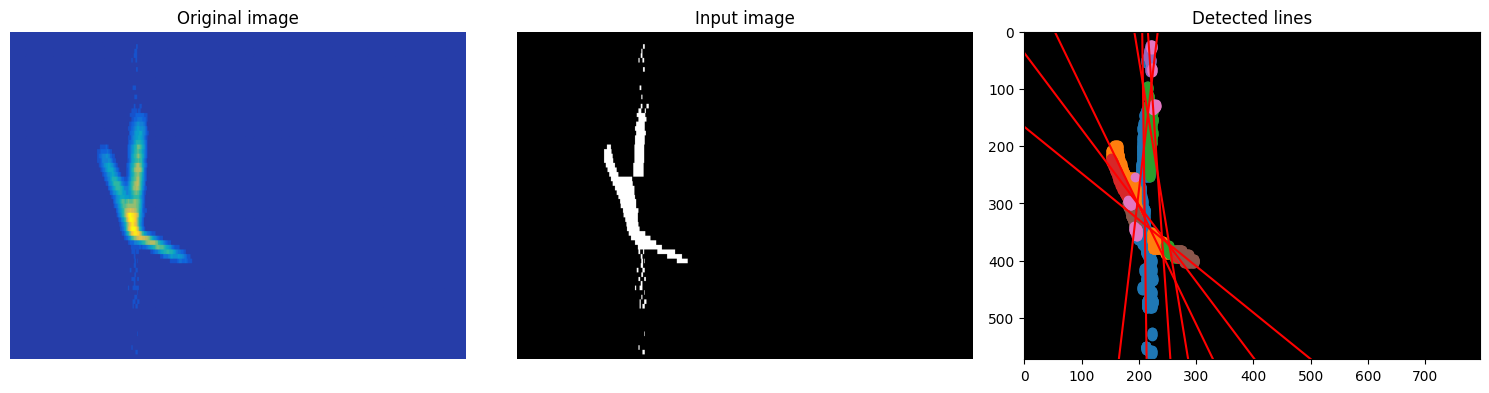

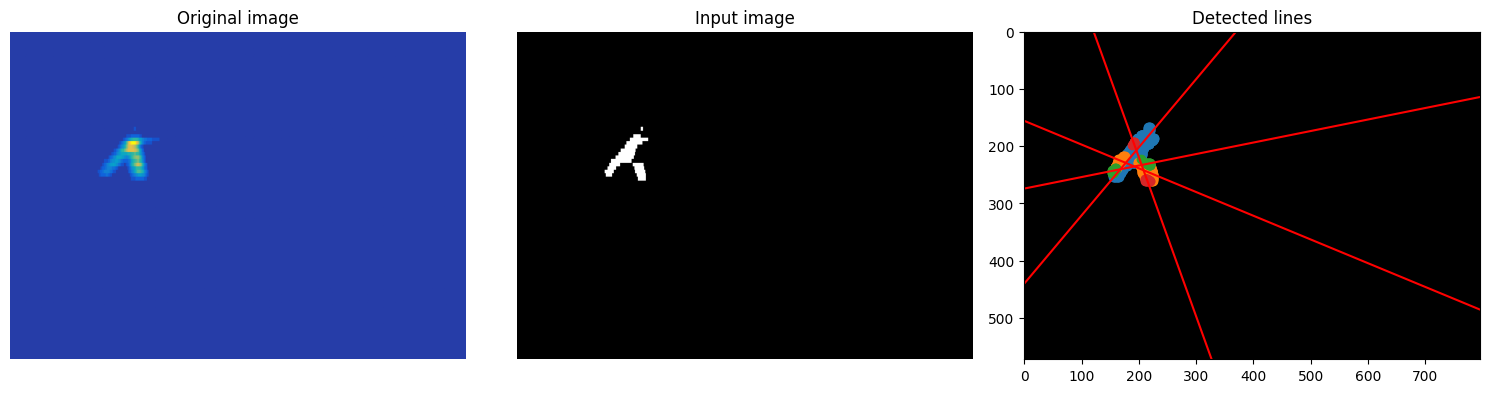

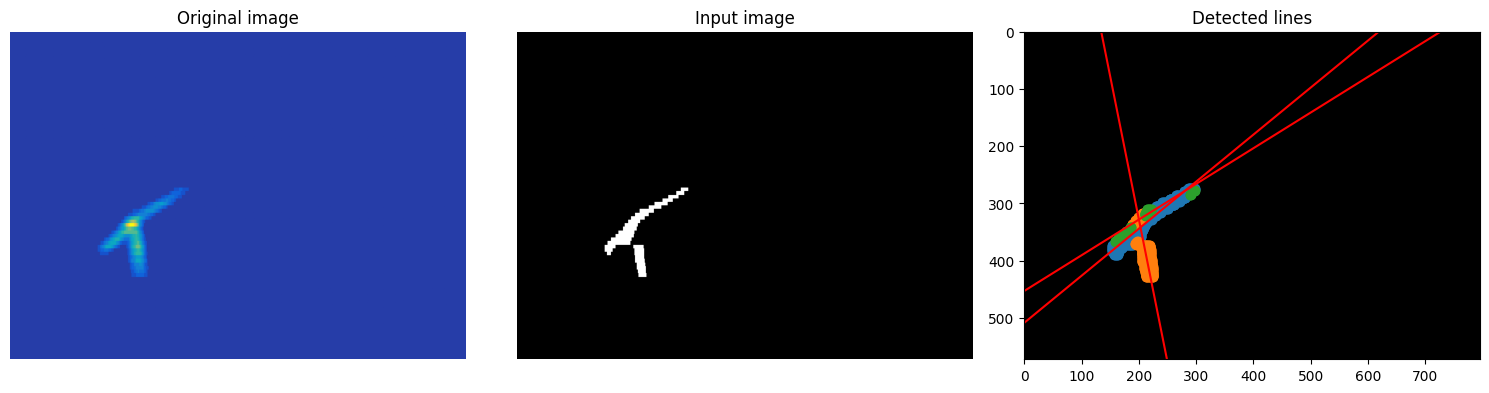

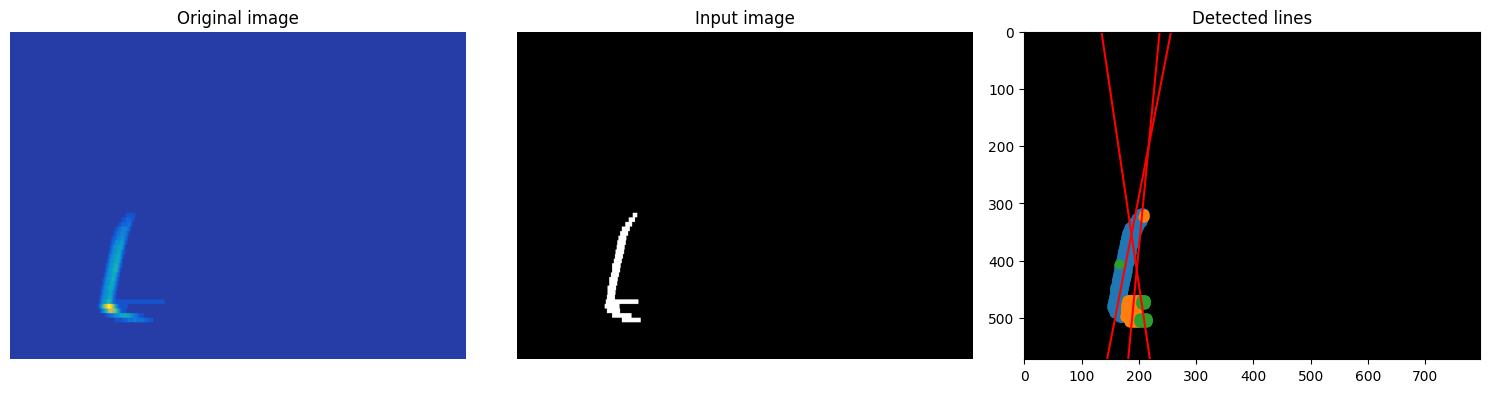

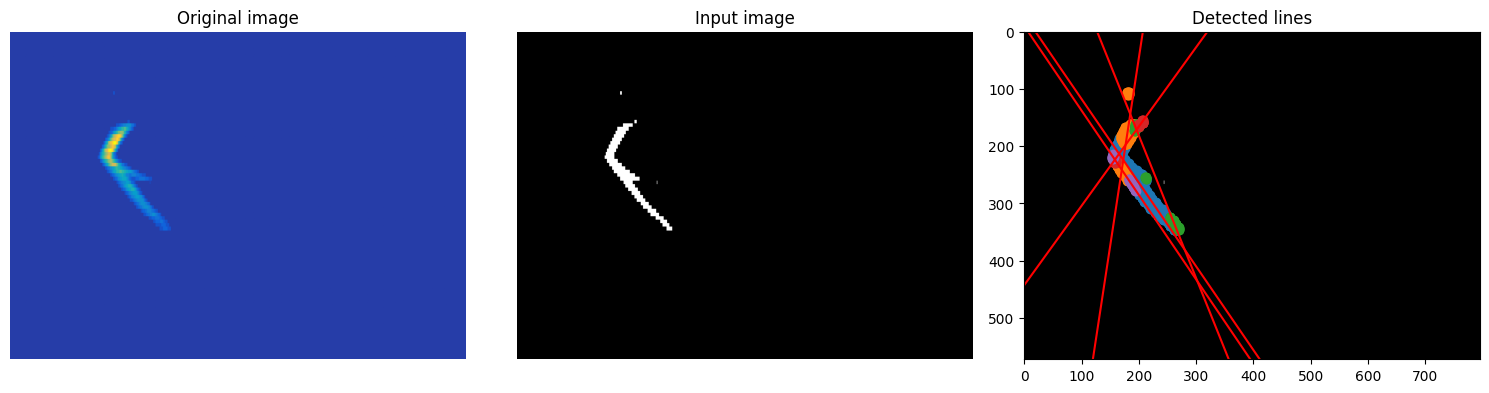

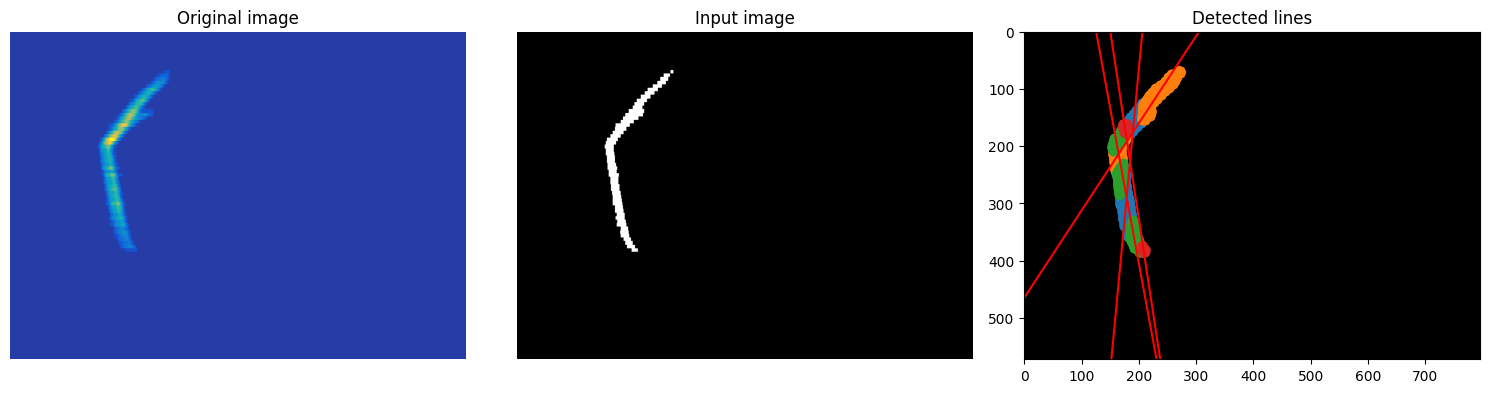

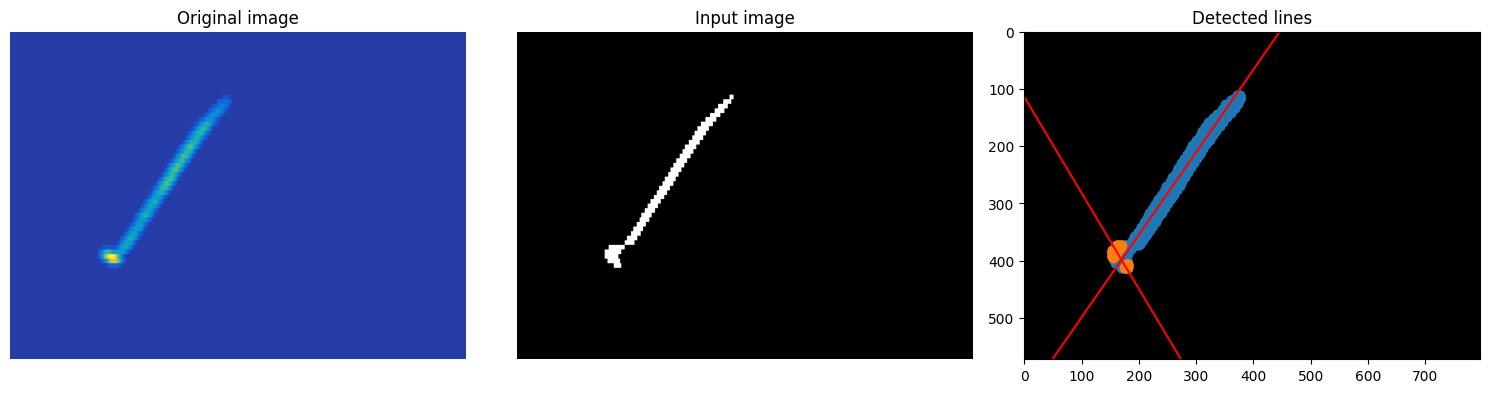

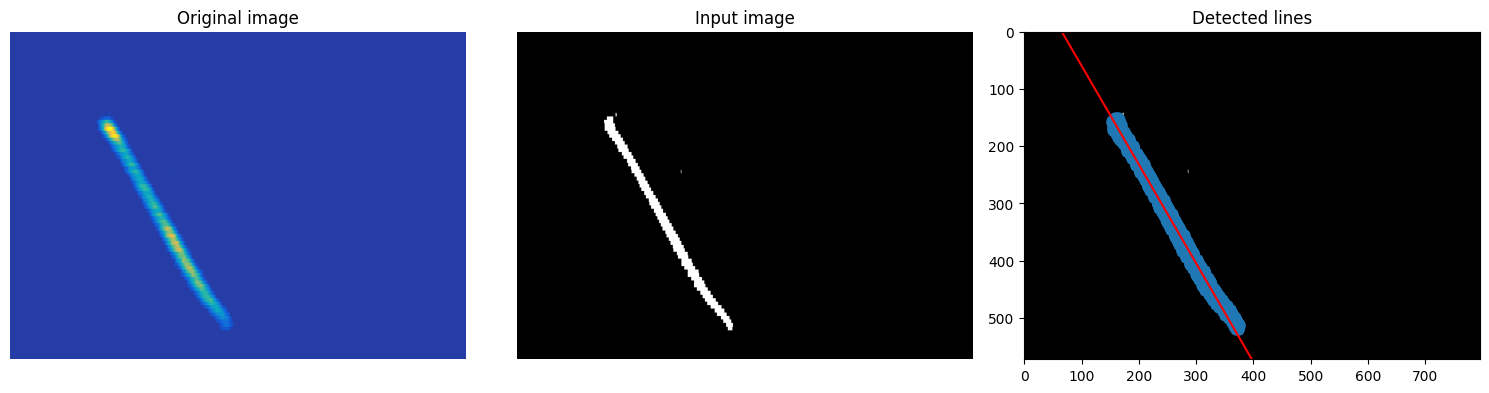

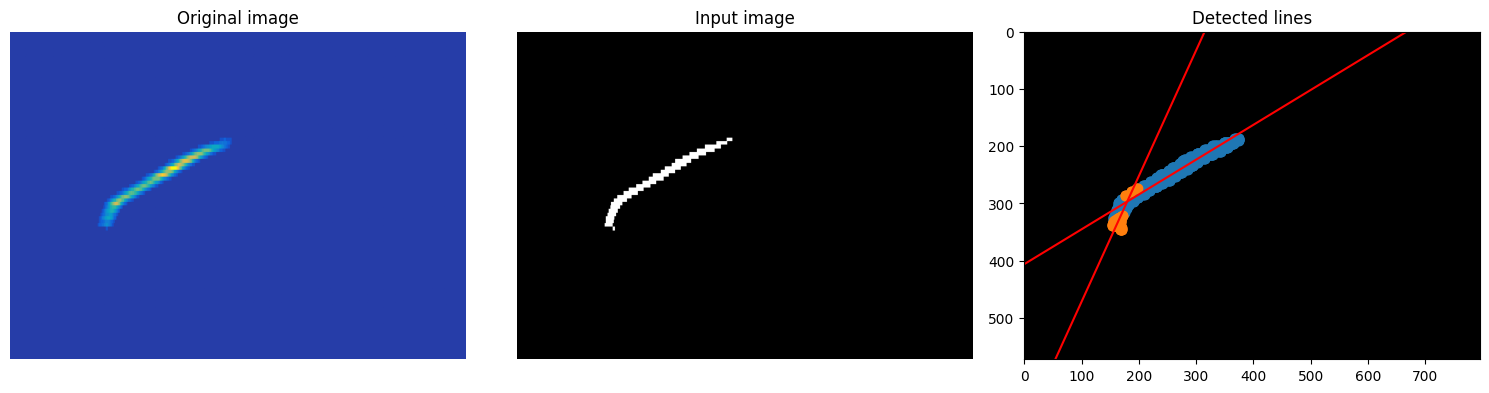

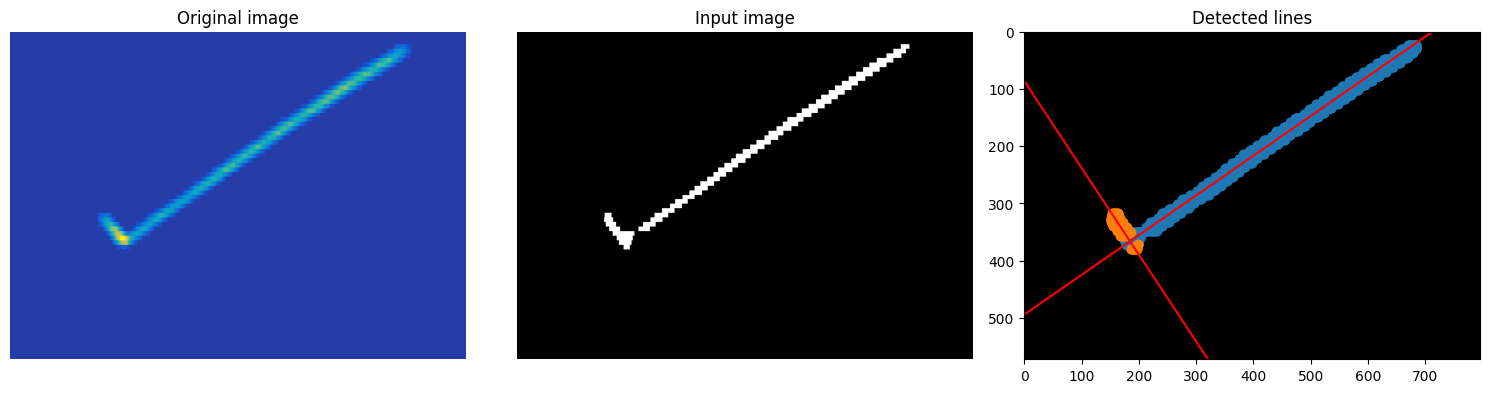

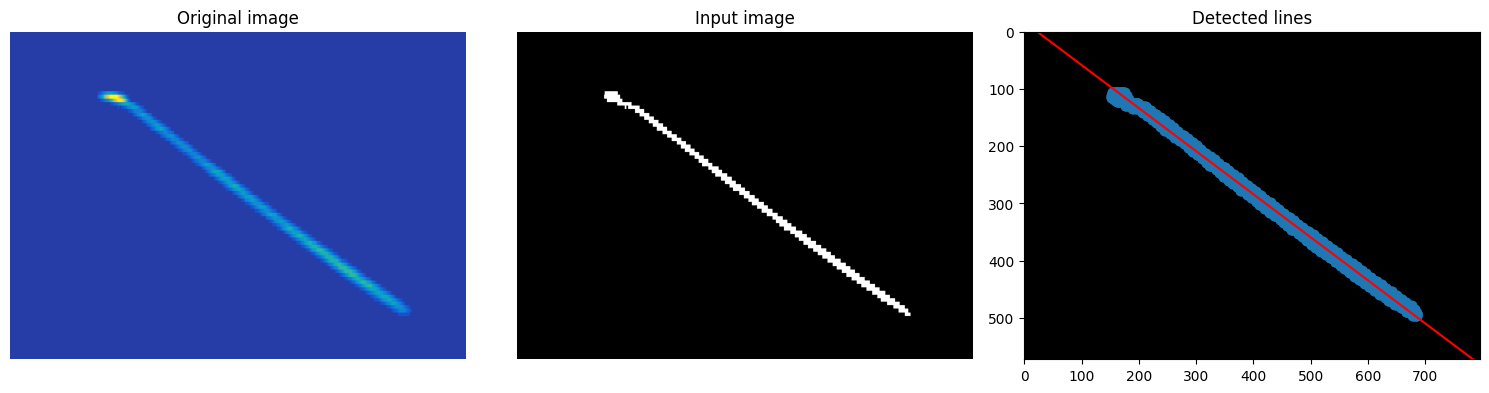

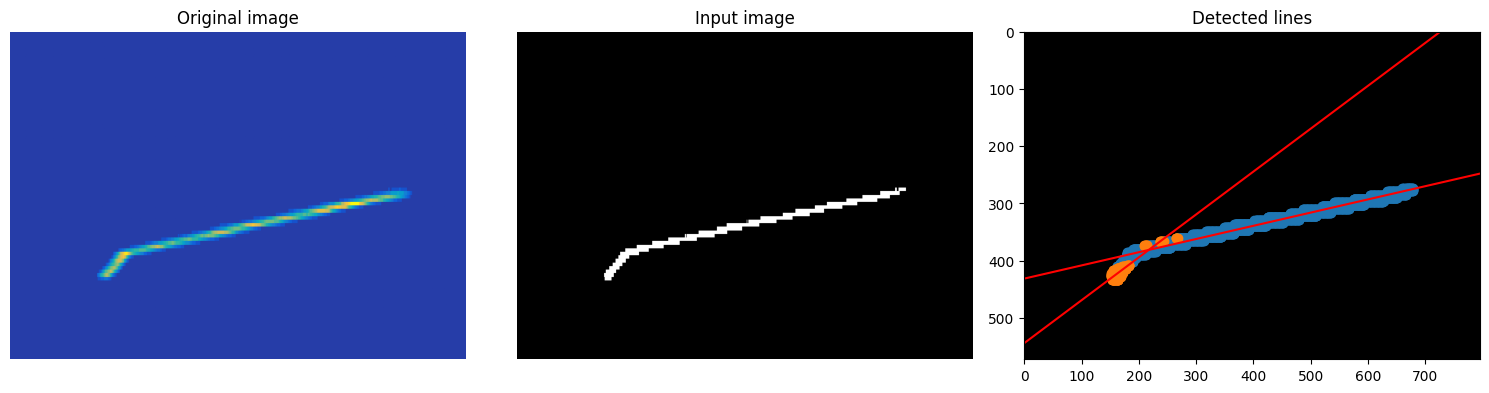

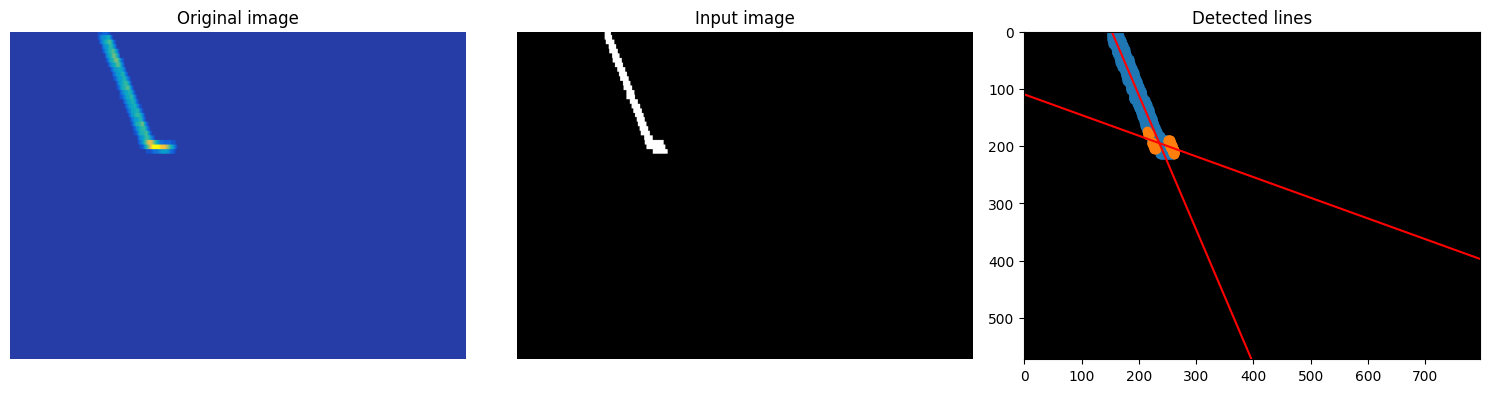

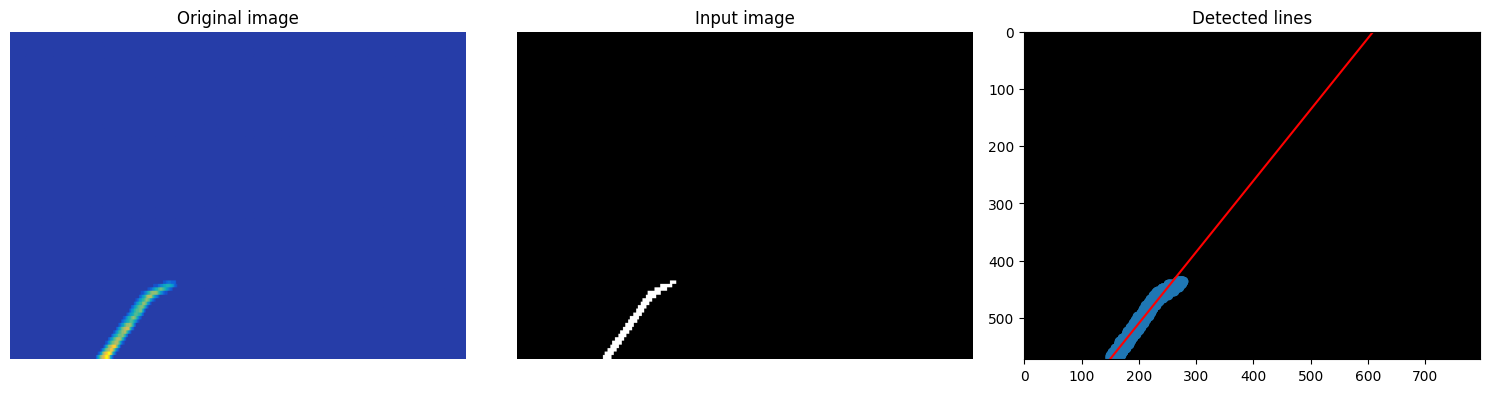

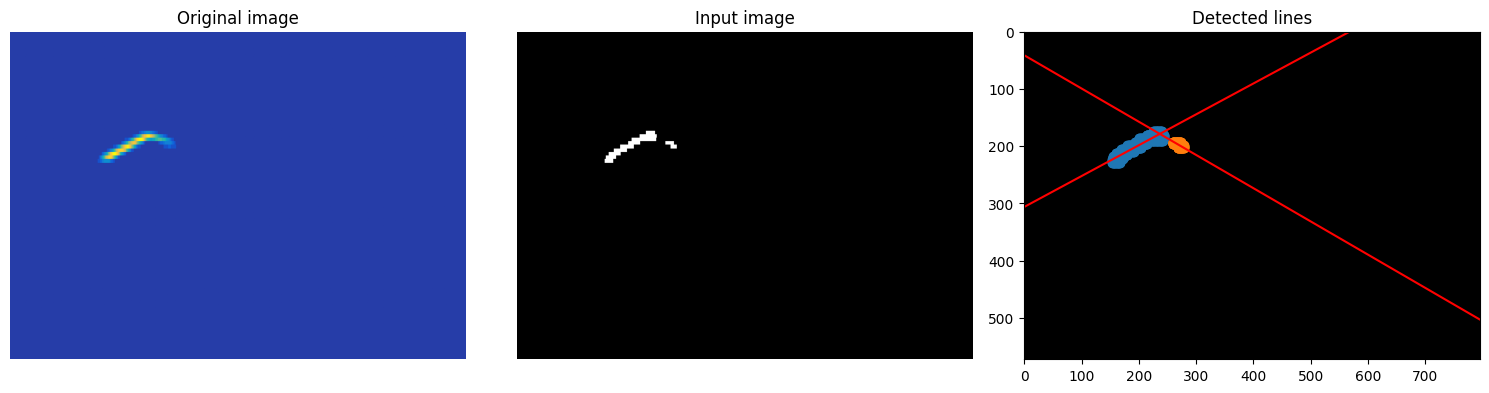

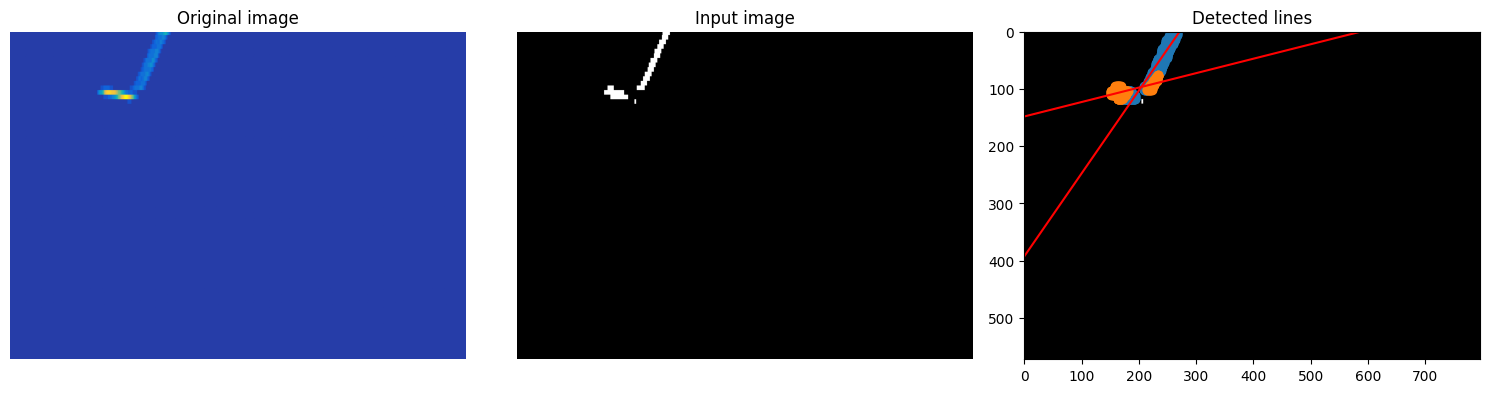

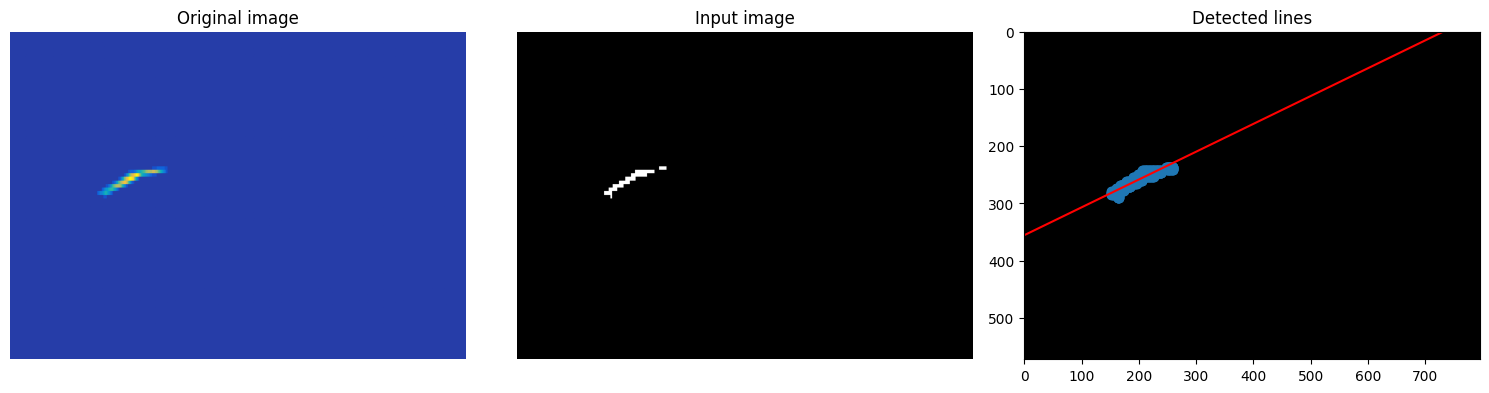

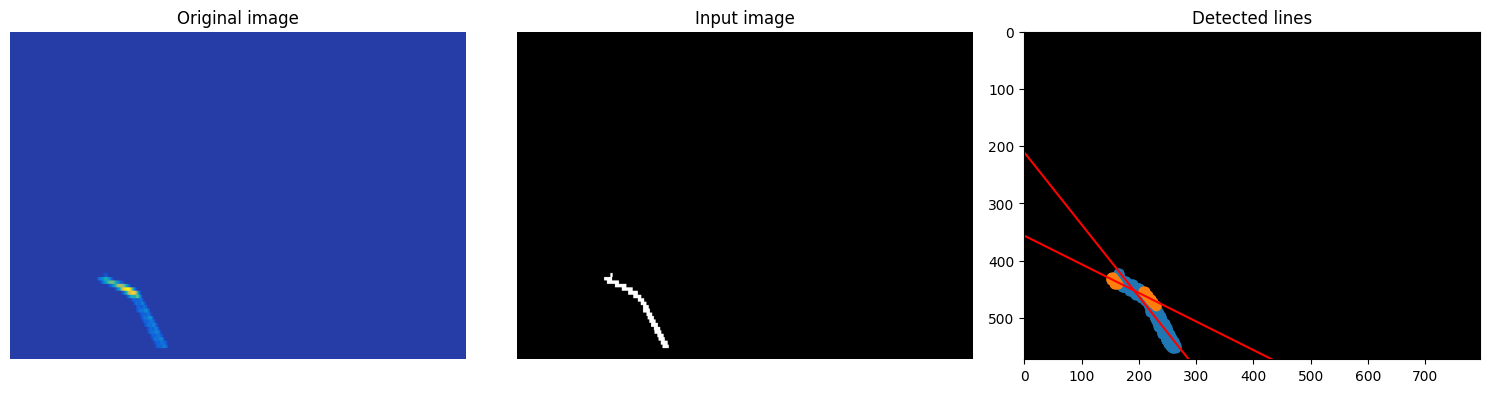

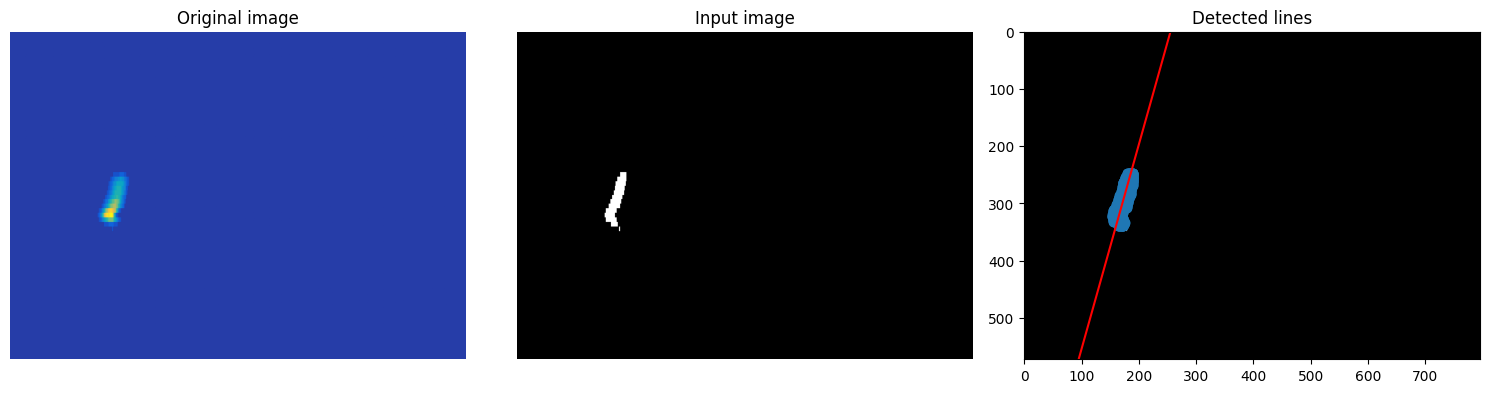

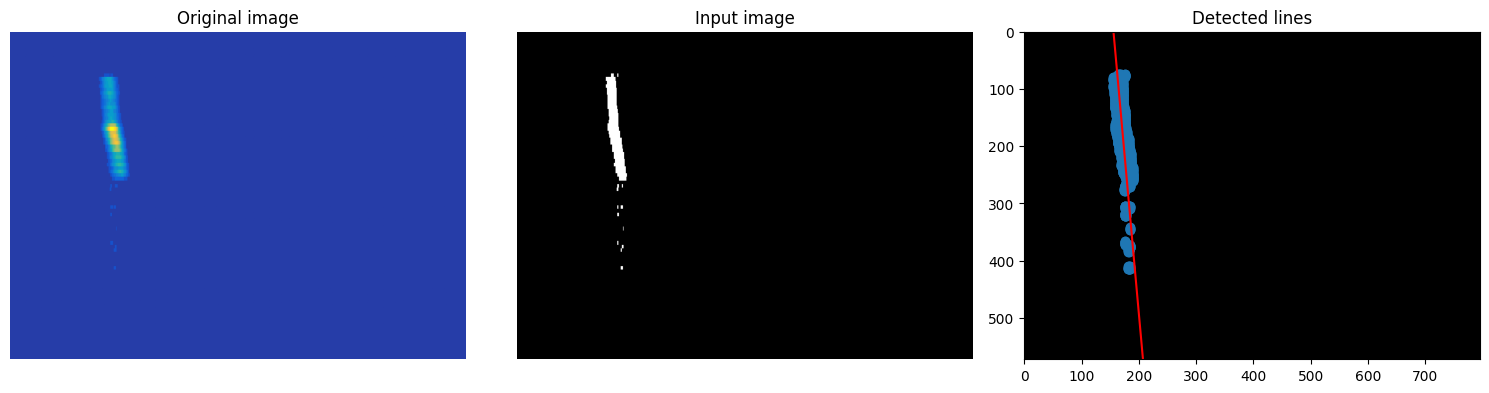

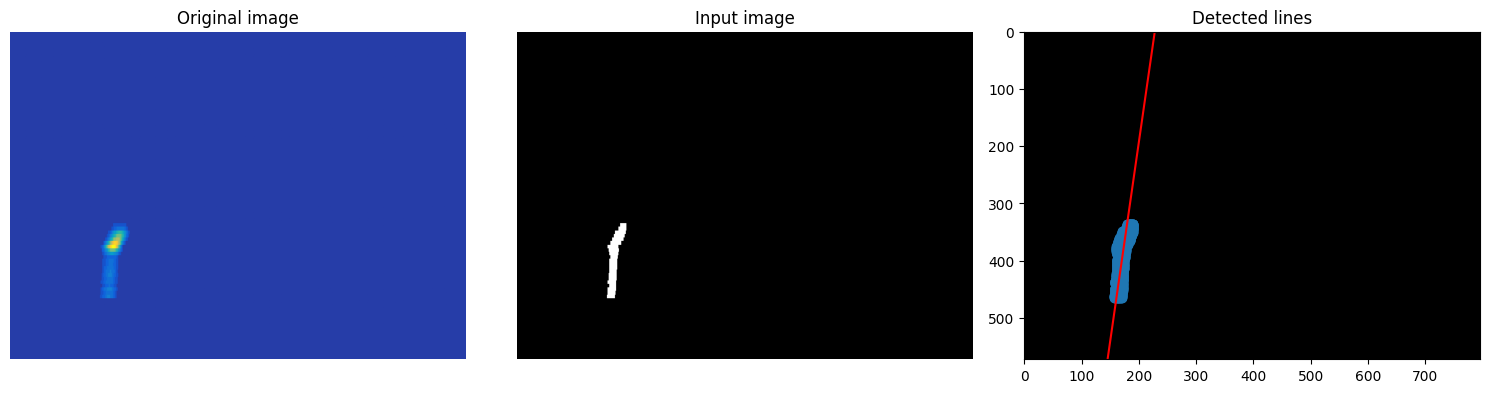

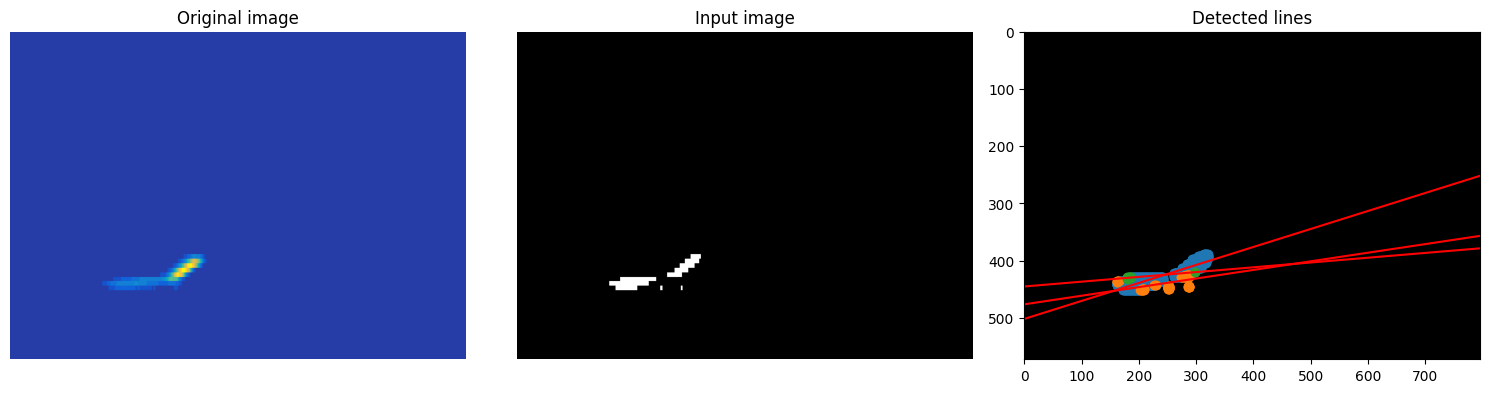

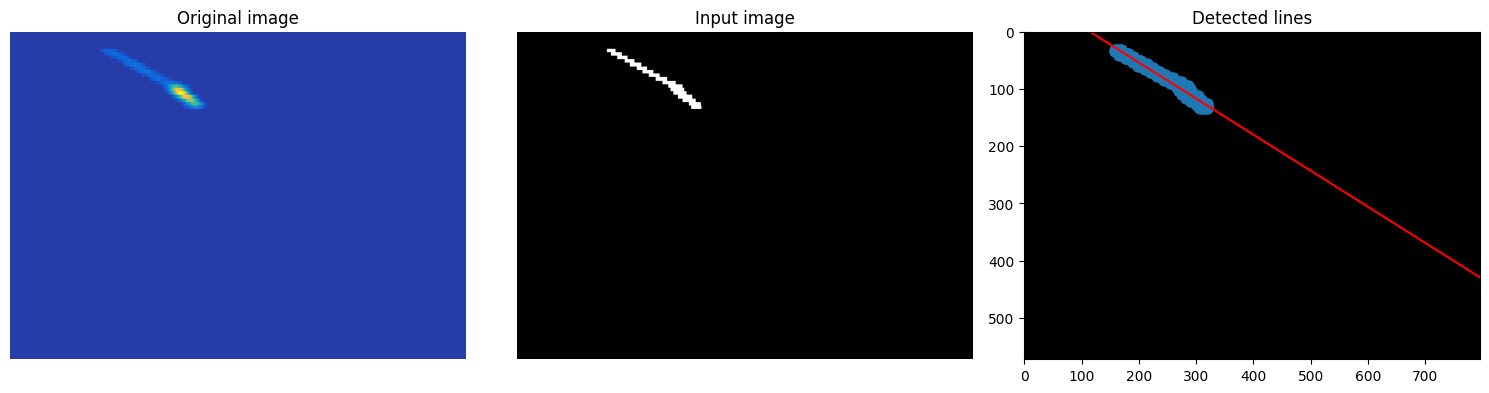

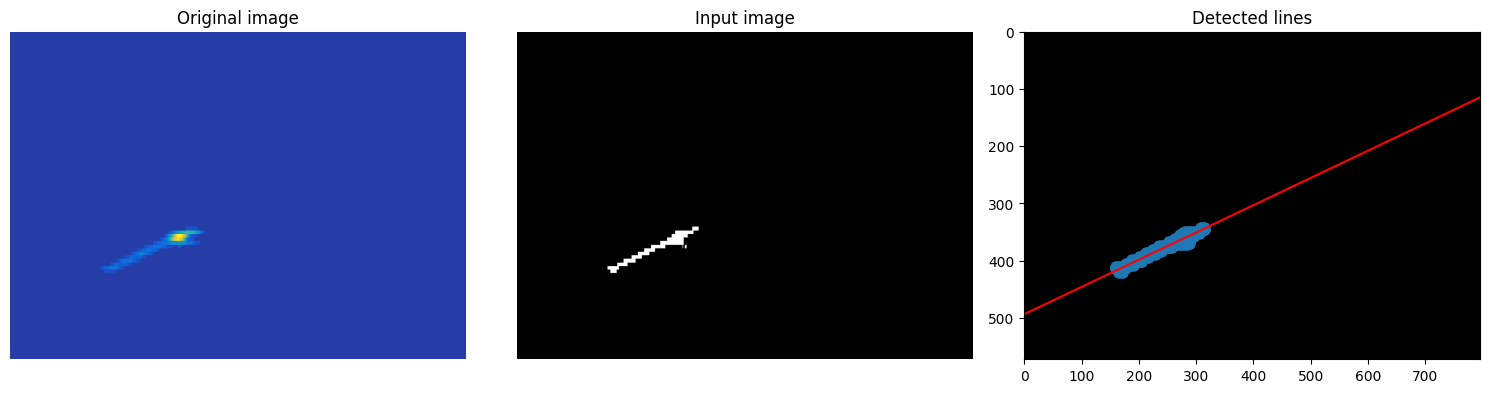

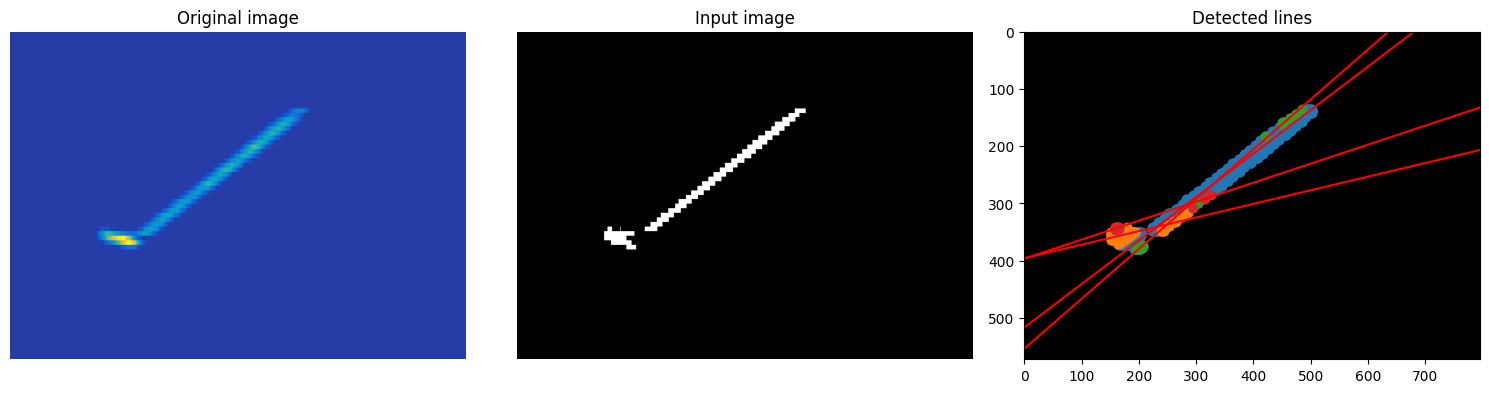

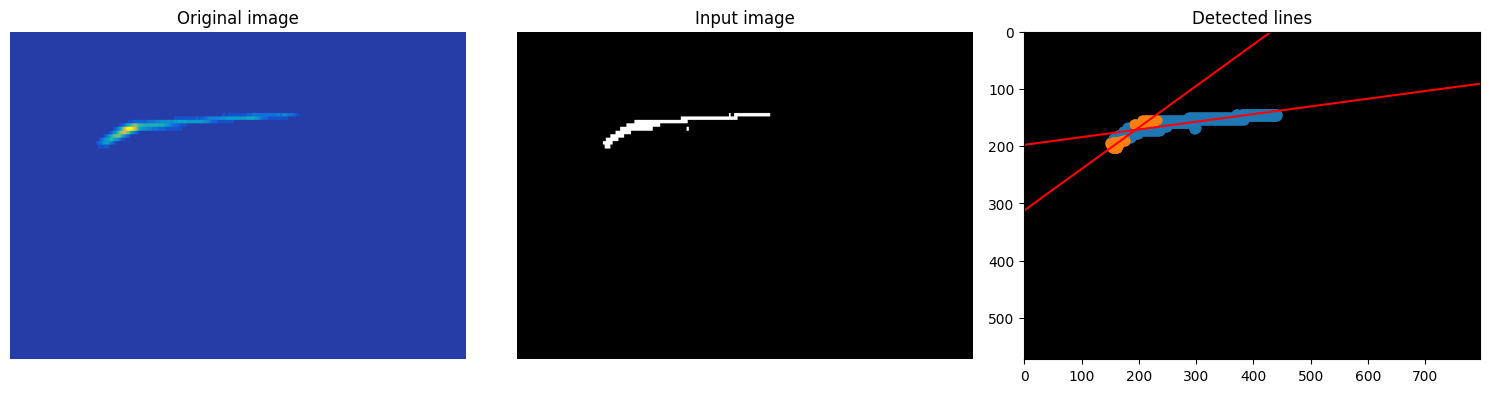

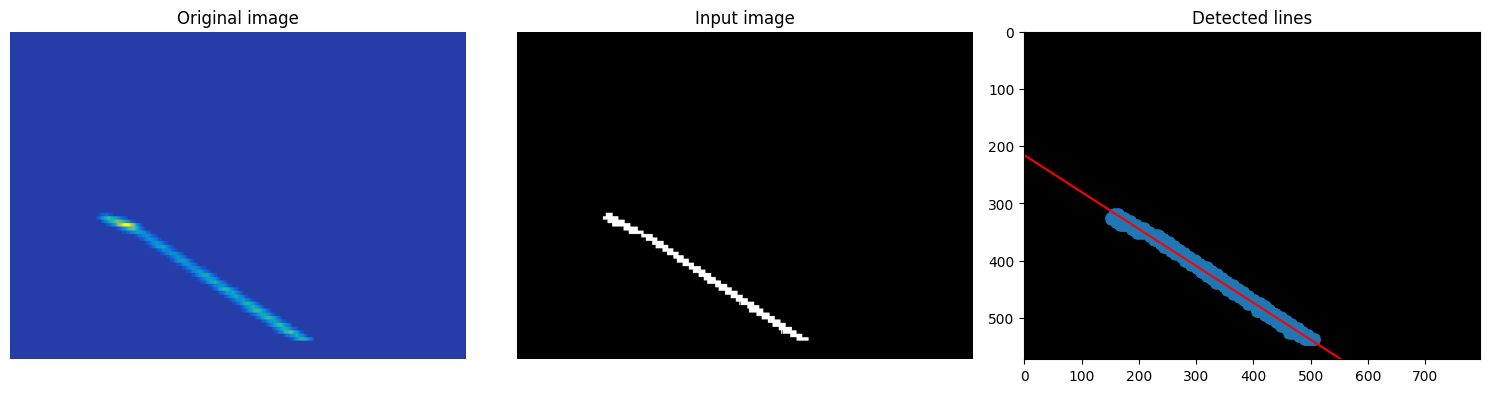

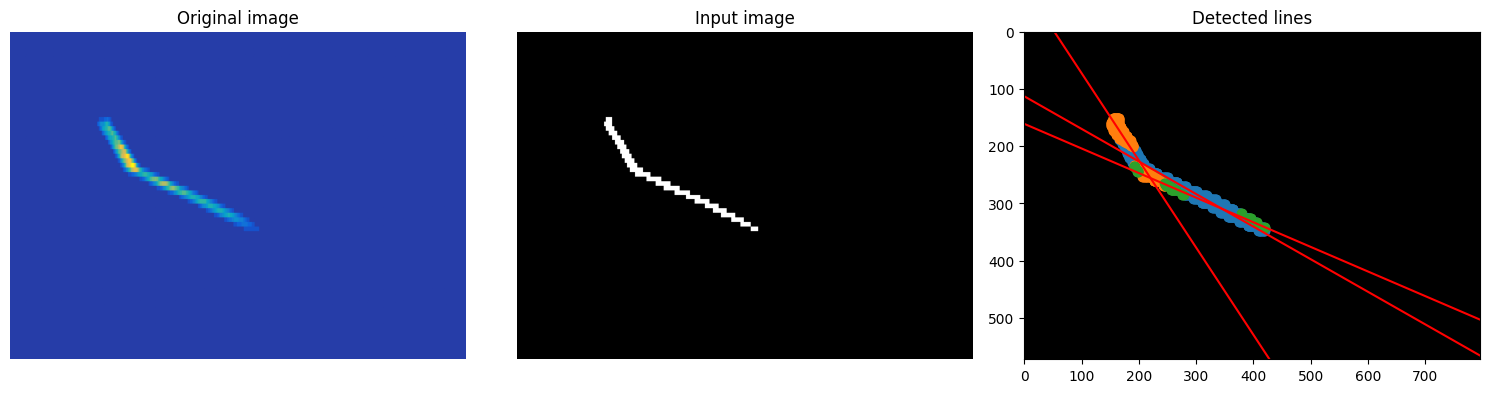

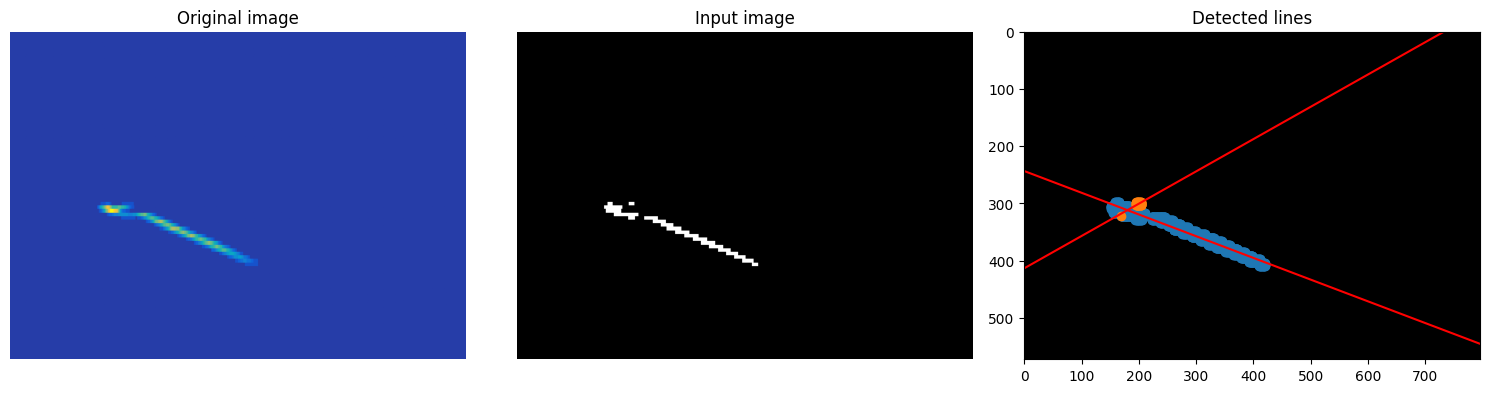

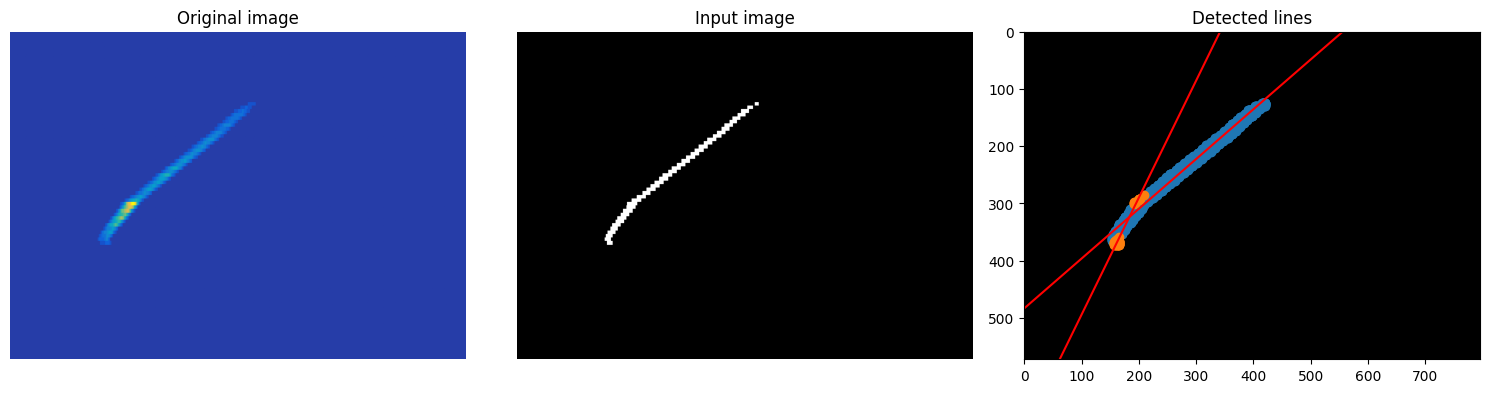

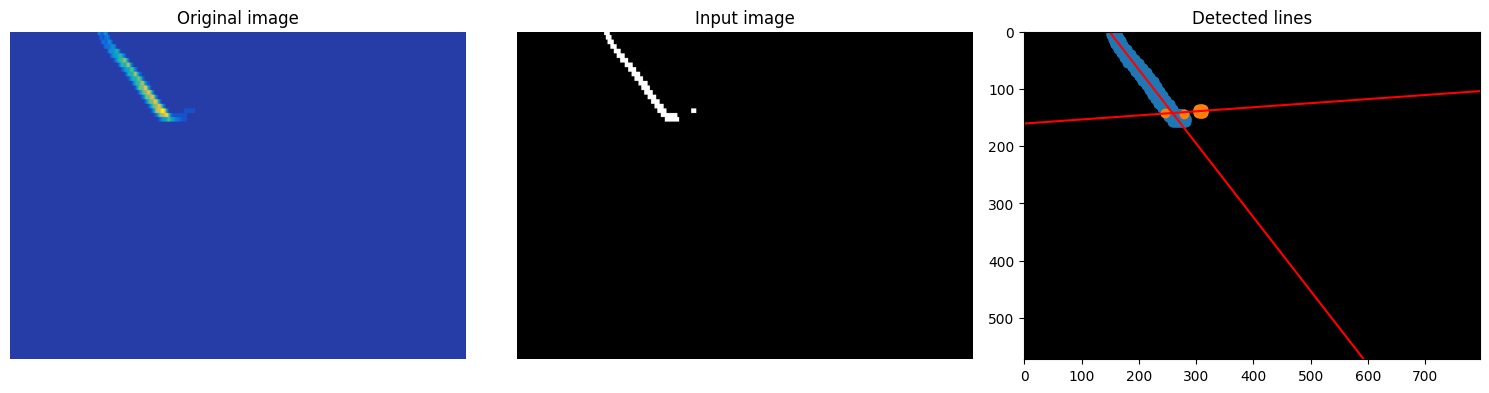

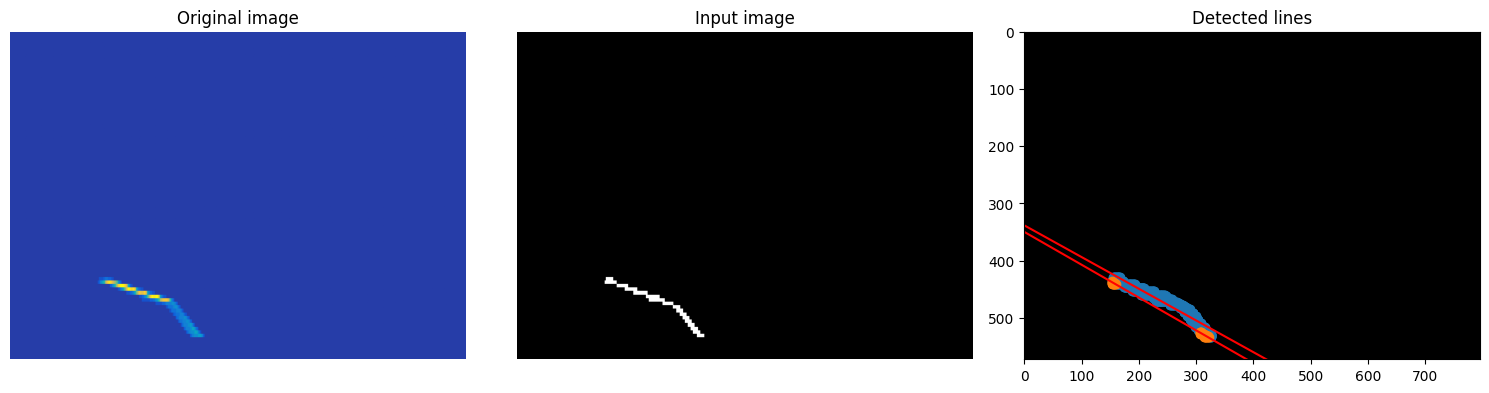

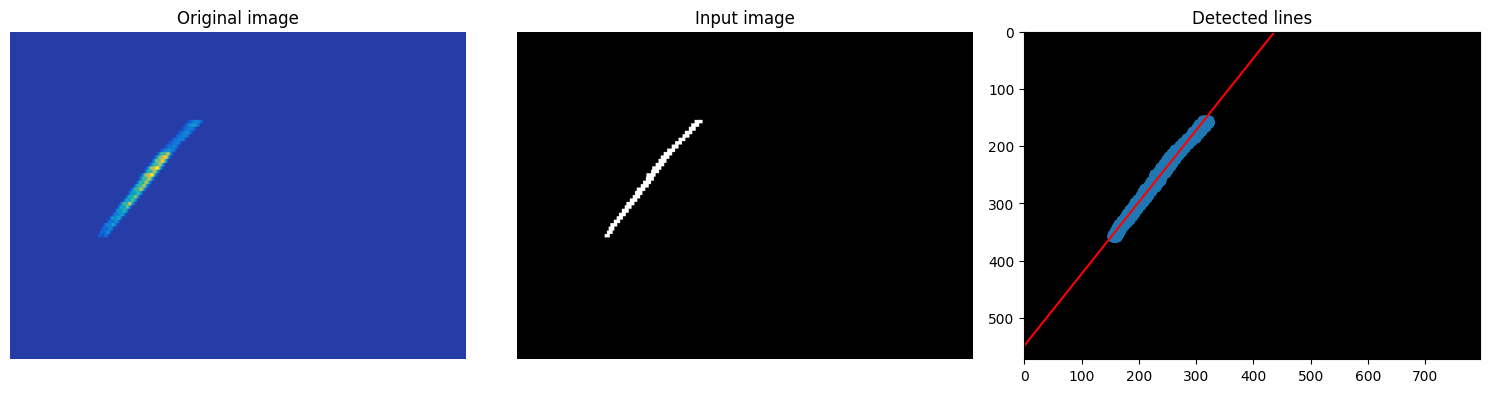

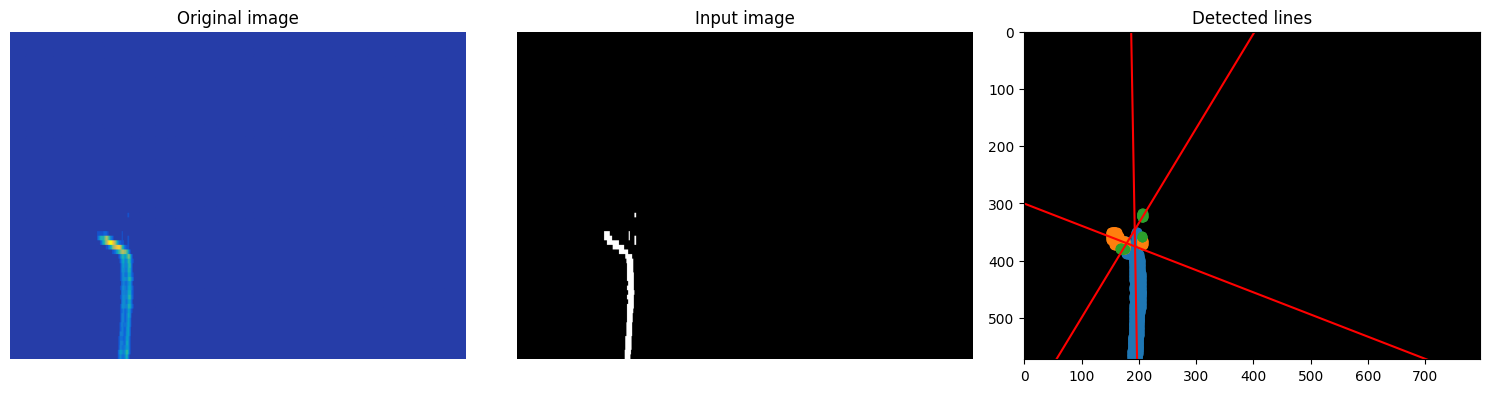

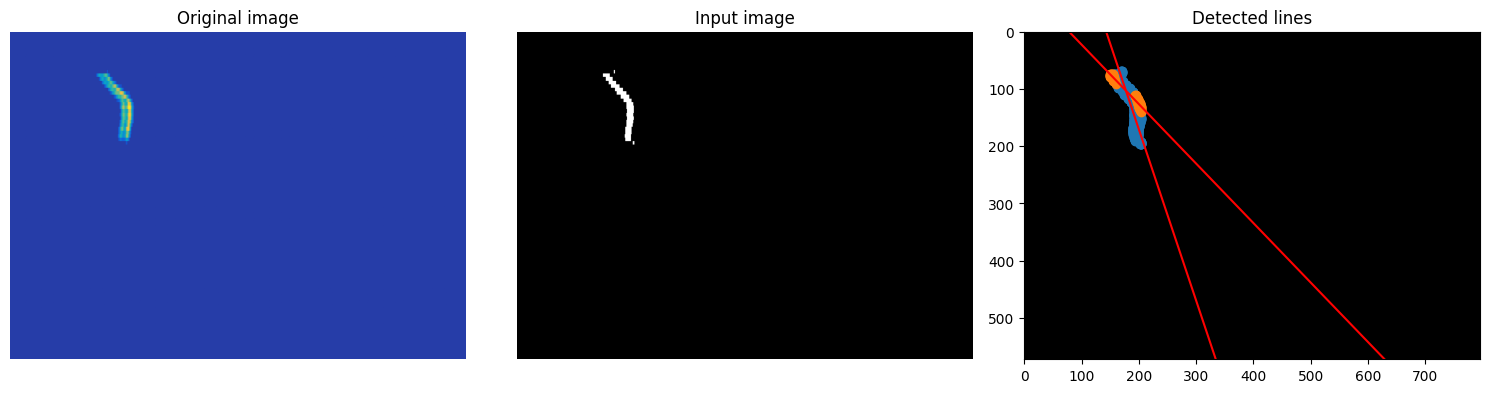

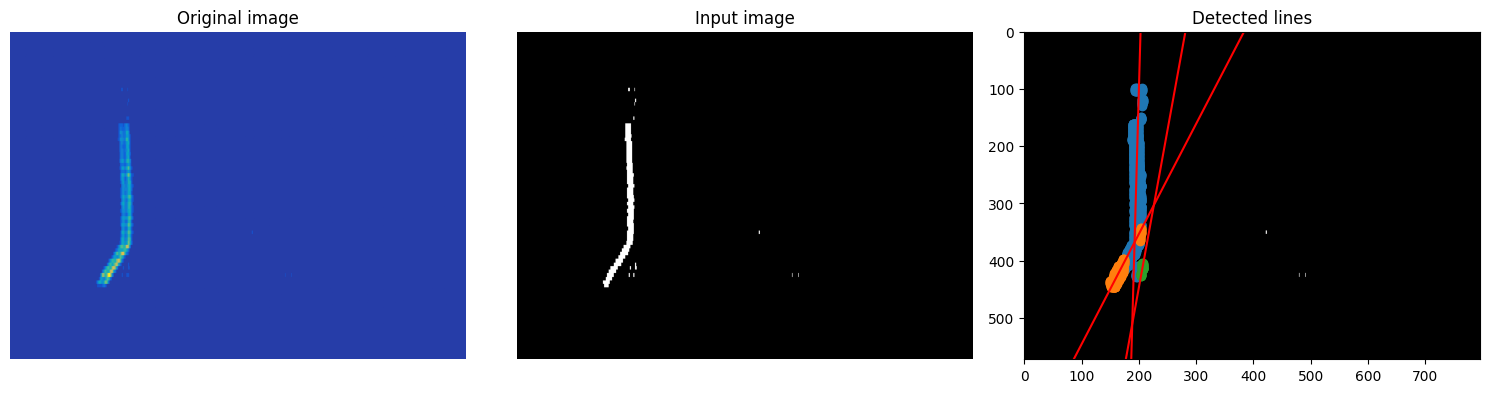

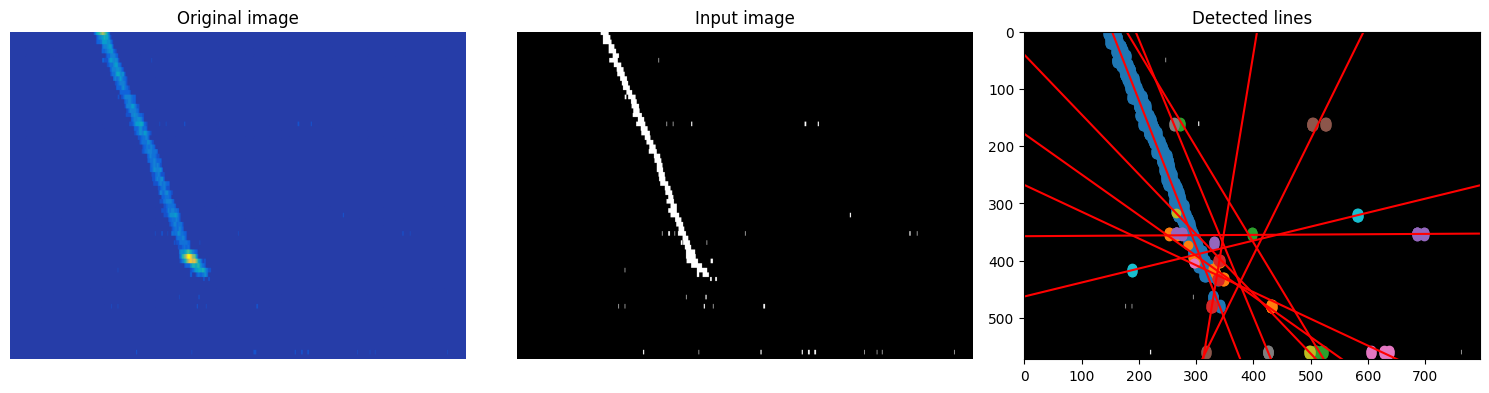

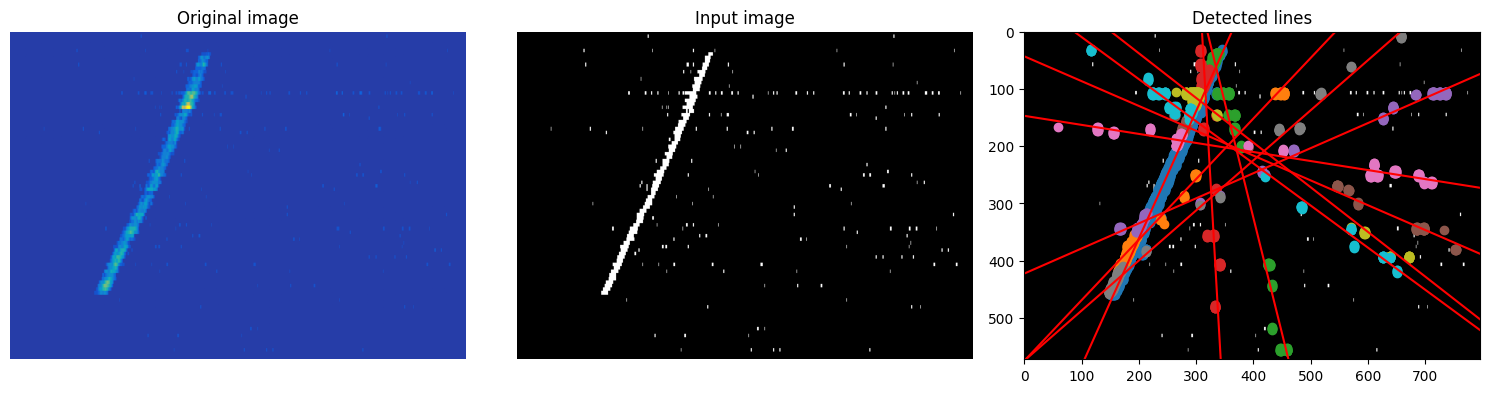

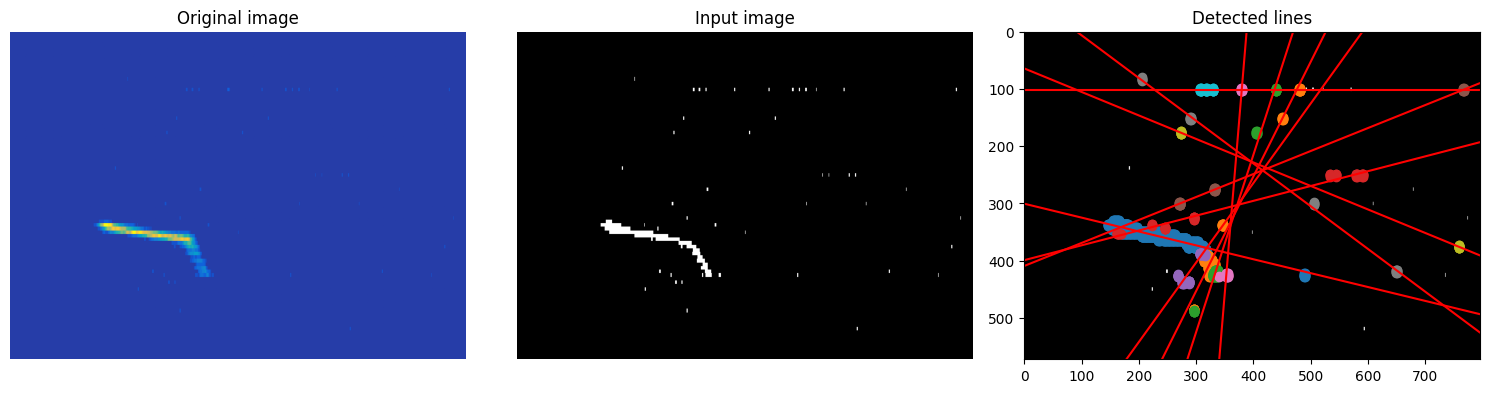

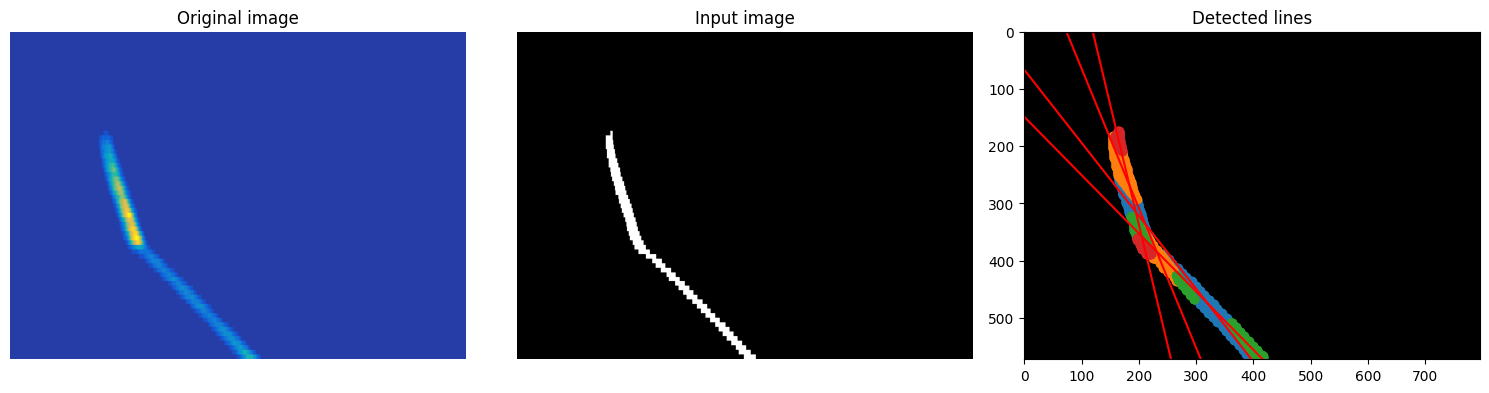

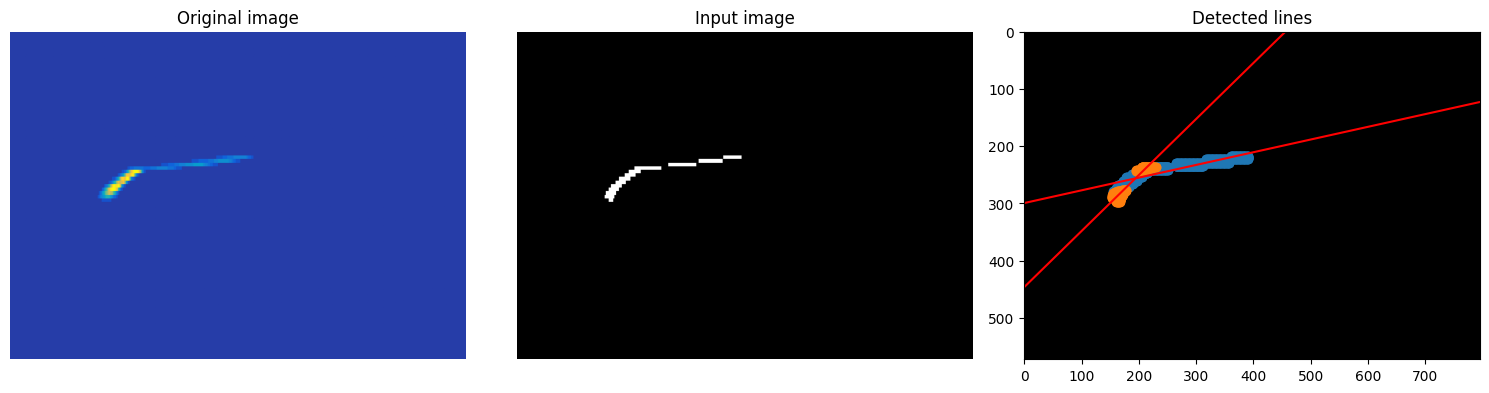

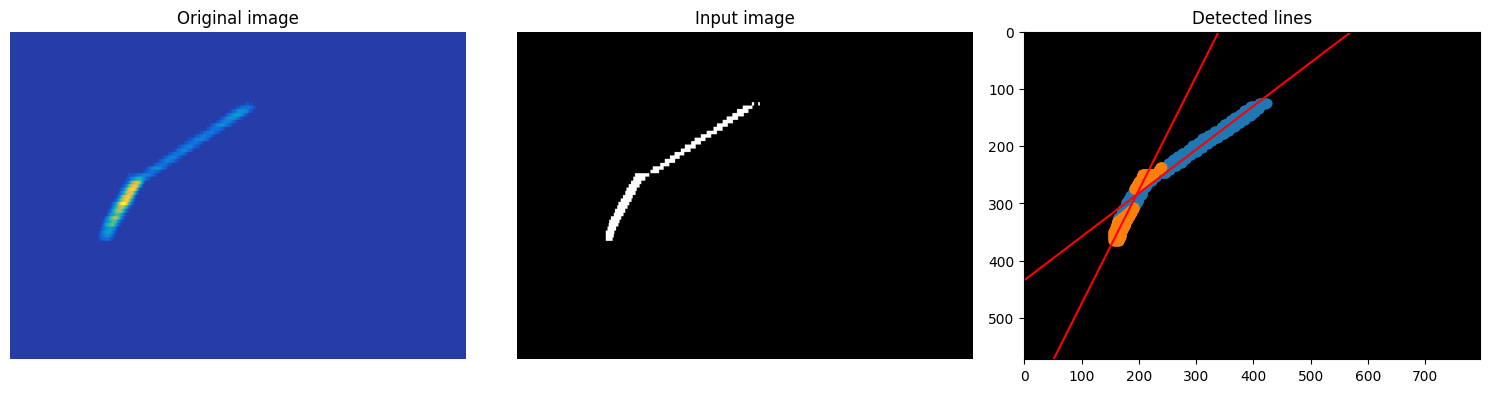

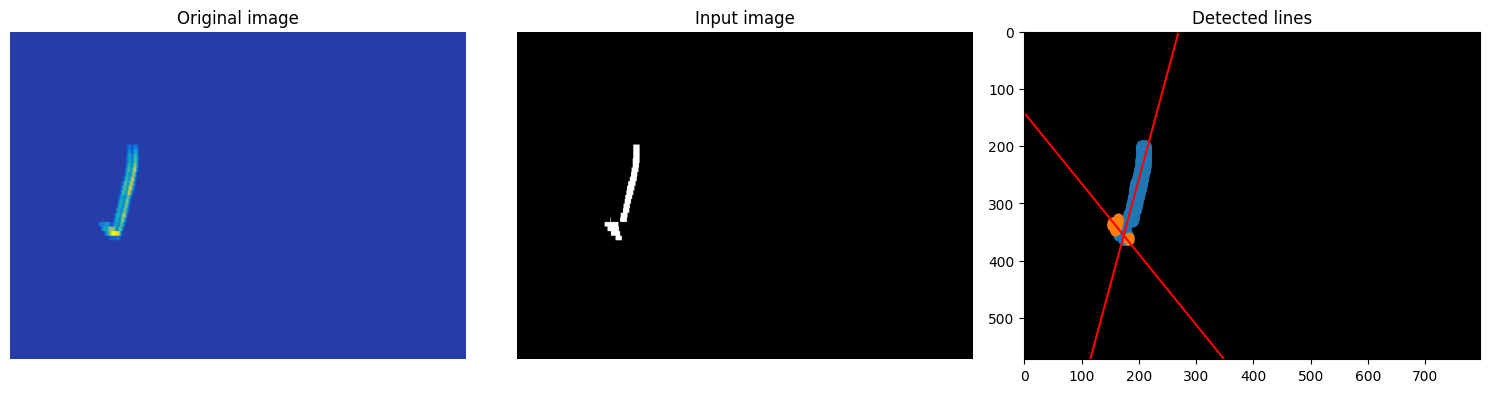

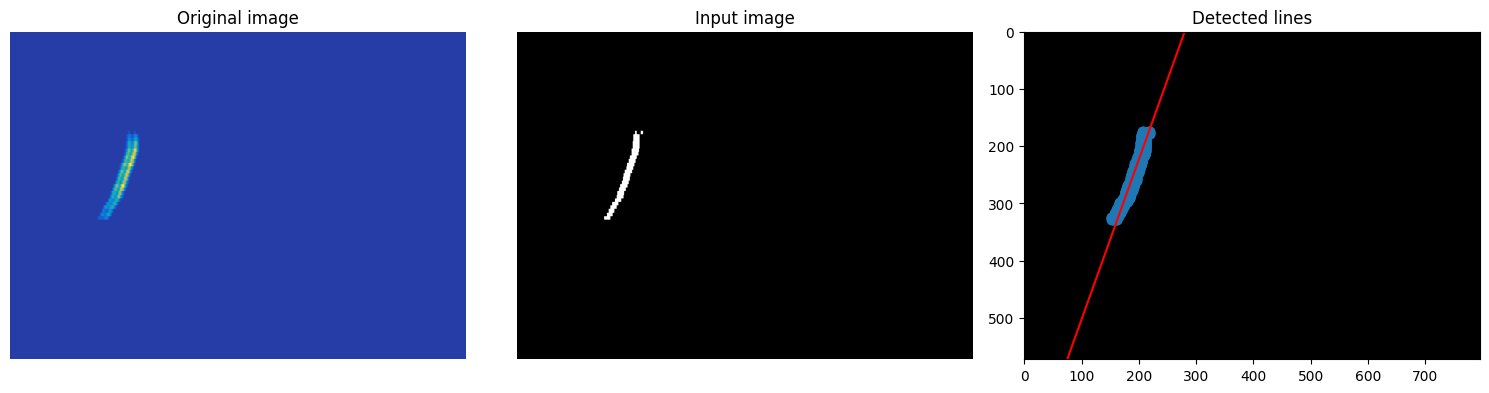

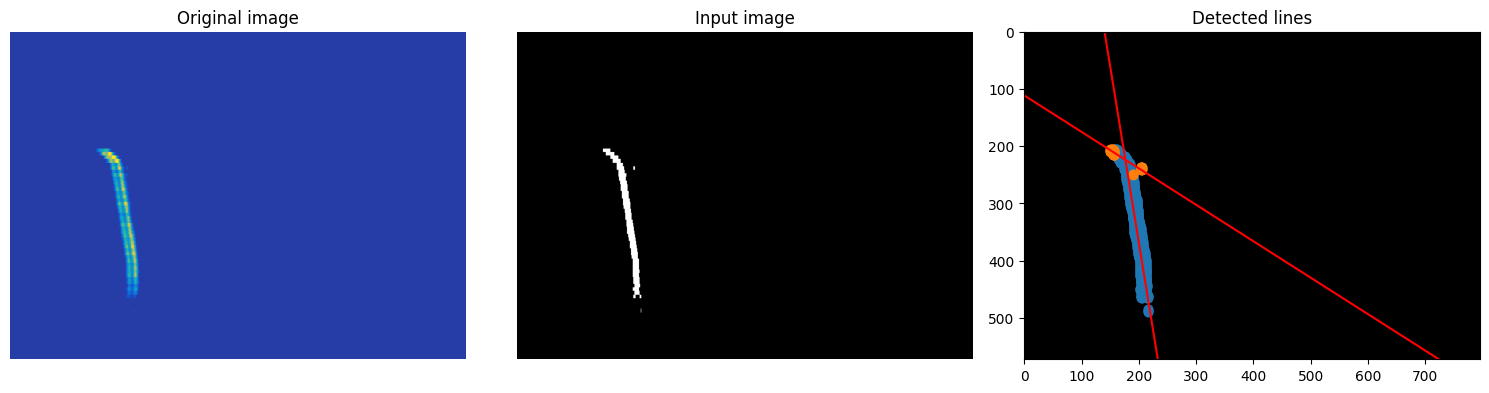

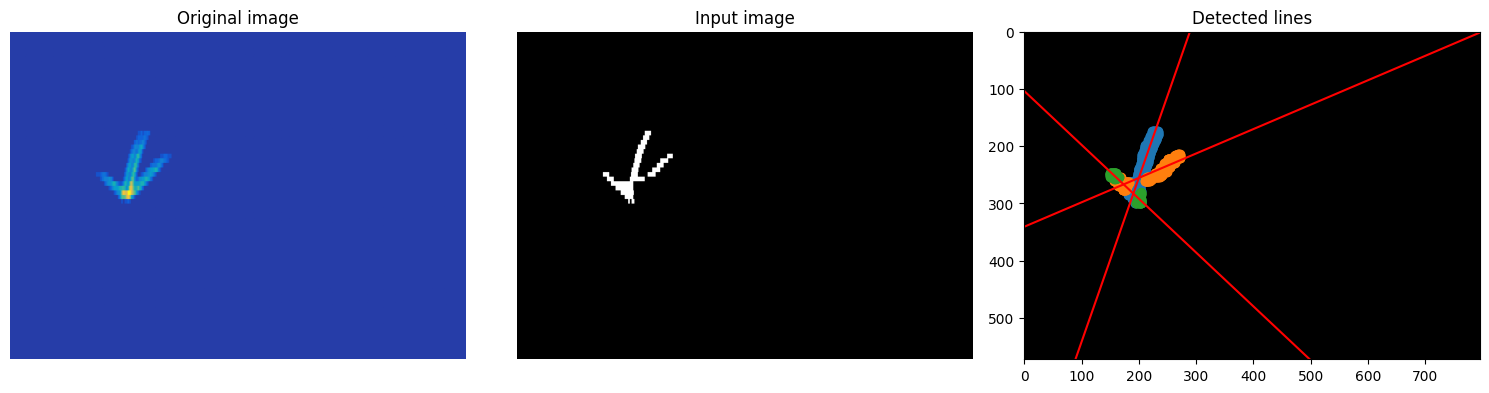

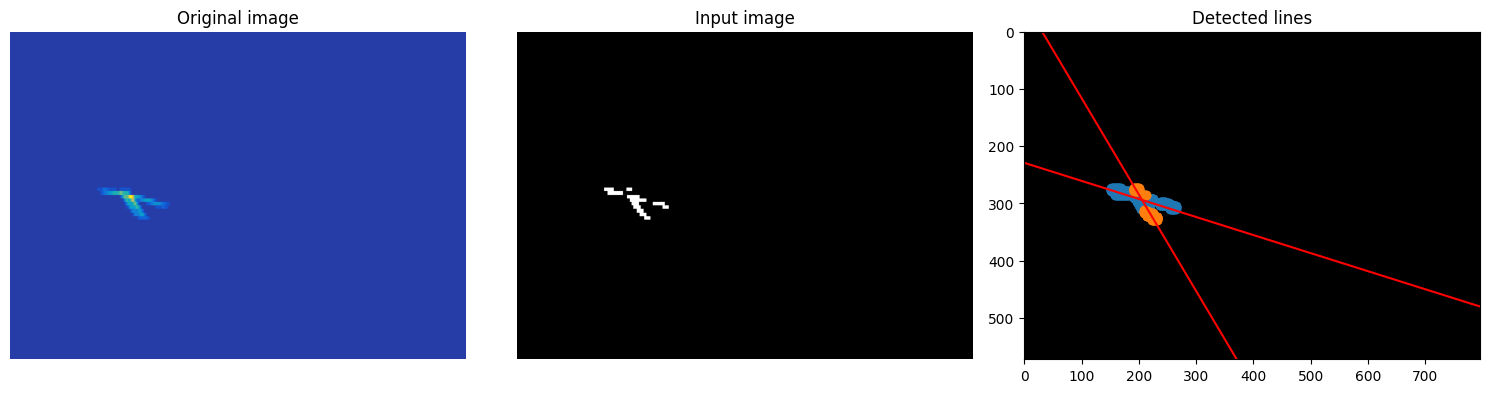

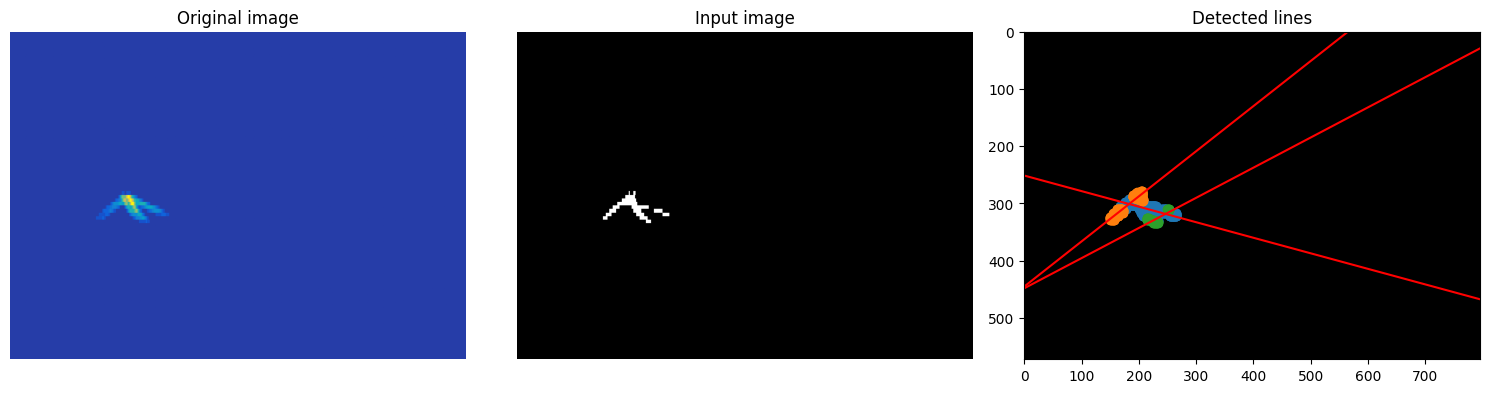

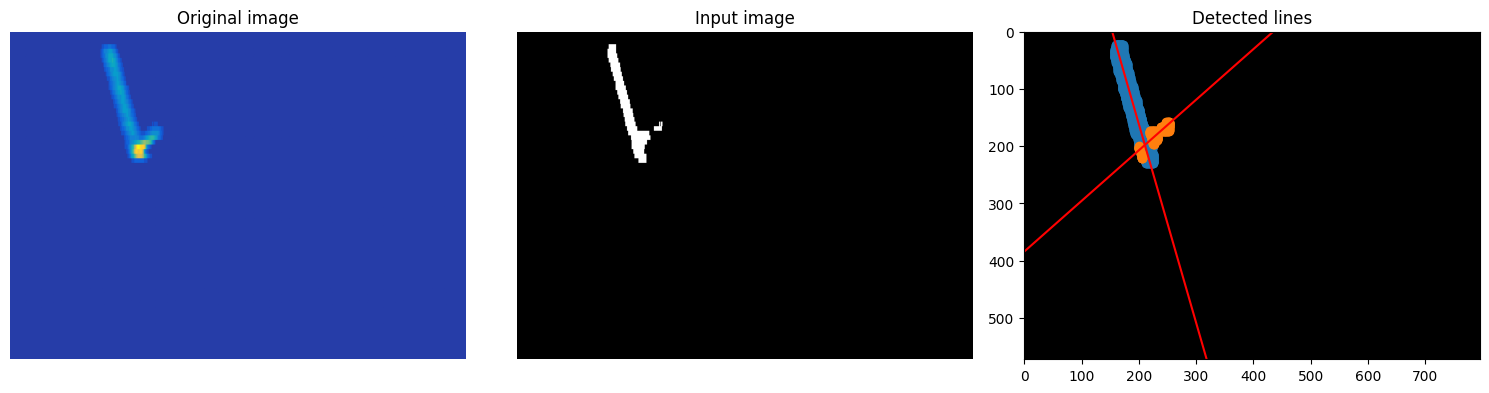

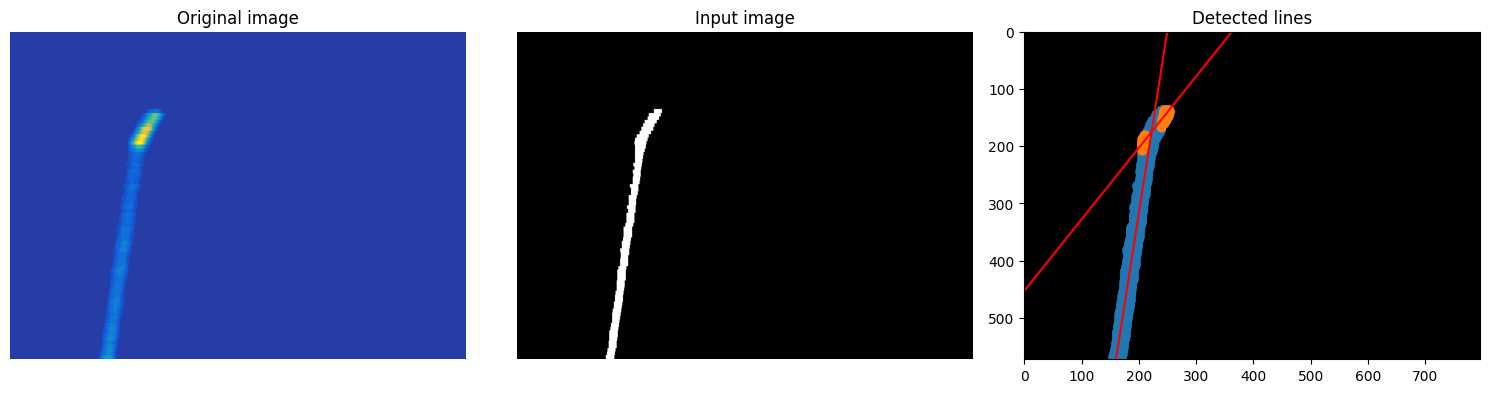

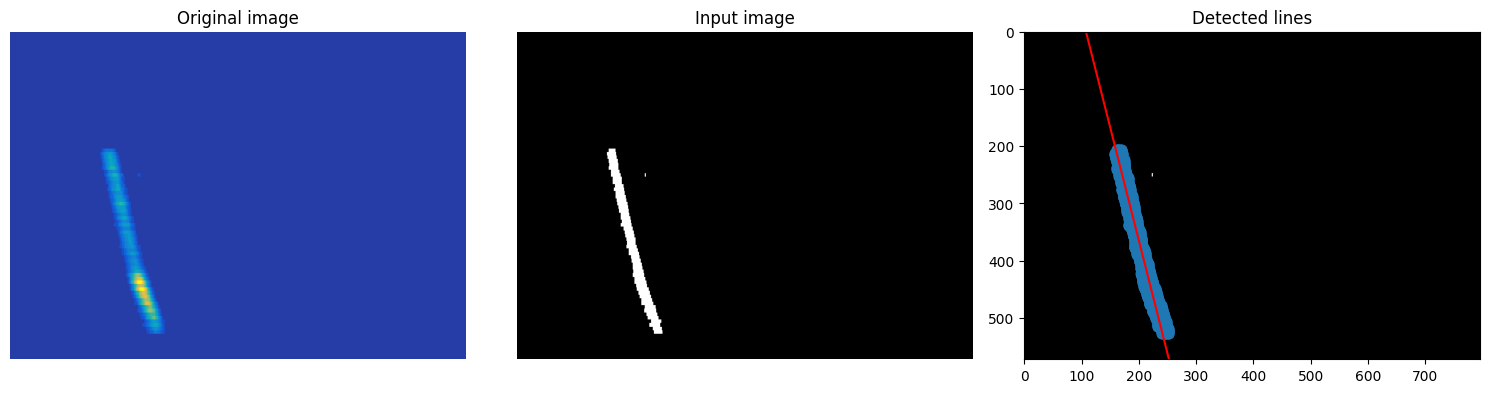

In [32]:
import sys
import os
sys.path.append("/home/gant/Documents/tpcanalysis/python_comp/src")
from openImage import openImage
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from skimage.color import rgb2gray
from skimage.measure import LineModelND, ransac



def processPixelSeries(series):

    middle_pixel = len(series) // 2
    series[middle_pixel:] = 0  # Set the right half to black
    half_width = len(series) // 2
    left_index = middle_pixel - half_width
    right_index = middle_pixel + half_width + 1
    series[right_index:] = 0  # Set the right half to black
    series[:left_index] = 0  # Set the left half to black

    return series

def processRow(row):

    # Find the indices where the consecutive series of 1s start and end
    starts = np.where(np.diff(np.concatenate(([0], row, [0]))) == 1)[0]
    ends = np.where(np.diff(np.concatenate(([0], row, [0]))) == -1)[0]

    # Iterate over the series and call the processPixelSeries function
    for start, end in zip(starts, ends):
        series = row[start:end]
        if len(series) > 4:
            row[start:end] = processPixelSeries(series)


        
    return row



def fitImage(path_and_name_input, path_and_name_output=None):

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    original_image = test_image.m_data

    #Black and white
    test_image.m_data = rgb2gray(test_image.m_data)
    test_image.m_data = np.where(test_image.m_data < 0.3, 0, test_image.m_data)
    test_image.m_data = np.where(test_image.m_data >= 0.3, 1, test_image.m_data)


    #This the line
    for row in test_image.m_data:
        processRow(row)

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image')
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('Input image')
    ax[1].set_axis_off()

    ax[2].imshow(test_image.m_data, cmap=cm.gray)
    ax[2].set_ylim((test_image.m_data.shape[0], 0))
    #ax[2].set_axis_off()
    ax[2].set_title('Detected lines')




    ransac_data = test_image.m_data

    points = np.argwhere(ransac_data == 1)[:, ::-1]

    min_samples = 20

    for i in range(10):

        if(len(points) < min_samples + 1):
            print(f"\nStopped at iteration number {i}")
            break

        model, inliers = ransac(points, LineModelND, min_samples=min_samples, residual_threshold=12.5, random_state=0)

        outliers = inliers == False

        ax[2].scatter(points[inliers][:, 0], points[inliers][:, 1]) 


        if(model.params[1][0] == 0):
            slope = 999 #temporary fix
        else:
            slope = model.params[1][1] / \
                model.params[1][0]
        intercept = model.params[0][1] - \
            slope * model.params[0][0]


        print(f"Equation: y = {slope}*x+{intercept}")
        #print(f"Line from {model.params[0][0]}, {model.params[0][1]} to {model.params[1][0]}, {model.params[1][1]}")


        x = np.arange(0, test_image.m_data.shape[1])
        #x = np.arange(points[inliers][:, 0].min(), points[inliers][:, 0].max())
        y = slope * x + intercept


        ax[2].plot(x, y, label="fitted line", color='red')

        points = points[outliers]



    plt.tight_layout()
    #plt.show()
    plt.savefig(path_and_name_output)



#Make sure the dirs exist befoe calling the function. Don't have time to make sure in code.
image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))
